# Calibration of GIWAXS Data with pyFAI in the Notebook

There's one part of every materials science workflow I know everybody loves: calibrating X-ray scattering area detector geometry! There are many reasons to look forward to this task:
* No single software package handles every special case
* No two beamlines use the same calibrant, detector, data file format, metadata encoding, spatial measurement conventions, etc.
* Calibrations can change multiple times during a single trip!
* Calibration was the last thing on your mind when you showed up to the beamline and wanted to start taking data

I am here to say... that these are mostly still unsolved problems. However, performing your calibration in a Jupyter notebook will at least bring some transparency to the process.

# Table of Contents <a name="contents"></a>
---

## [0. Loading Data](#data)
> ### [0.0 I/O with `fabio`](#fabio)
> ### [0.1 Seeing Data](#imshow)

## [1. Calibration](#calib)
> ### [1.0 Detectors](#det)
> ### [1.1 Calibrants](#rings)
> ### [1.2 The Fitting Problem](#fitting)
> ### [1.3 Optimization in Python](#optim)

## 0.0 I/O with `fabio` <a name='fabio'></a>
---

[Back to TOC](#contents)

The first thing we need to be able to do is load raw detector data. pyFAI recommends the [fabio](https://pythonhosted.org/fabio/api/modules.html#module-fabio.pilatusimage) library for this purpose. It's essentially an image i/o module for the file types commonly coming off of area detectors.

In [1]:
import fabio

/anaconda/envs/pygix/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


For this tutorial, I've organized a calibration image, a blank image, and an image from a good representative sample in the `data/calibration` folder. We can see those files with a sample `Path.glob()`:

In [2]:
from pathlib import Path
data_dir = Path('data/calibration/')
data_files = list(data_dir.glob('*.tiff'))
data_files

[PosixPath('data/calibration/AgBH_5m_11kev_cali_th0.000_5.00s_2011731_waxs.tiff'),
 PosixPath('data/calibration/DPP_100_Opt5_AS_0_th0.150_15.00s_998170_waxs.tiff'),
 PosixPath('data/calibration/Siwafer_ref_th0.150_15.00s_998210_waxs.tiff')]

We can see that `data_files[0]` will be our calibration image, `[1]` will be the sample, and `[2]` will be the blank. I've ensured that angle of incidence and exposure time are the same for the blank and sample to keep things simple. Let's try opening the sample image with `fabio.open()`. The input needs to be a string (note that above, `glob()` returned PosixPath objects).

Let's break that list up into nice variable names.

In [3]:
calib_file = str(data_files[0])
sample_file = str(data_files[1])
blank_file = str(data_files[2])
sample_file

'data/calibration/DPP_100_Opt5_AS_0_th0.150_15.00s_998170_waxs.tiff'

In [4]:
img = fabio.open(sample_file)
img

Fabio throws warnings *all the time*, but I have never had an actual issue. "Bogus stripBytes count" is another fun one. Feel free to explore other TIF i/o modules - I have no particular reason for using this one other than it was recommended and it works.

The fabio module has lots of functionality. `.data` is basically the only attribute we'll ever access, though. Let's go ahead and make "img" just the data array from now on.

In [5]:
img = img.data
img

array([[   0, 1002, 1006, ..., 1002, 1002, 1001],
       [1006,  999, 1003, ..., 1006, 1001, 1003],
       [1001,  997, 1003, ..., 1006, 1000, 1002],
       ...,
       [1002, 1005,  998, ..., 1010,  999, 1004],
       [1000, 1007, 1005, ..., 1009, 1009,  998],
       [ 998, 1003, 1005, ..., 1002, 1001, 1009]], dtype=uint16)

That's our image array! I want to look at that. Looks like we're already at the next section.

## 0.1 Seeing Data <a name='imshow'></a>
[Back to TOC](#contents)

Not much to say here. Same old %magic and matplotlib imports to start things off.

In [6]:
%matplotlib notebook
%config InlineBackend.figure_format = 'retina' # Comment this line out if your monitor is 1080p or less

from matplotlib import pyplot as plt
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True,  # Set good defaults for plot aesthetics
                 'xtick.top': True,
                 'xtick.direction': 'in',
                 'ytick.right': True,
                 'ytick.direction': 'in',
                 'font.sans-serif': 'Arial',
                 'font.size': 12,
                 'savefig.dpi': 300,
                 'figure.dpi': 96
                })
import numpy as np  # Also import numpy

### Raw scattering data frequently has odd distributions.

Let's take a look at the range of values before trying to do anything.

In [7]:
print('Min:', img.min(), '\nMax:', img.max(), '\nMean:', img.mean())

Min: 0 
Max: 63126 
Mean: 1020.3976600808279


That's a pretty insane max value. I find that a quick 3x3 median filter is frequently good for de-zingering.

In [8]:
from scipy.signal import medfilt
img_filt = medfilt(img)
print('Min:', img_filt.min(), '\nMax:', img_filt.max(), '\nMean:', img_filt.mean())

Min: 0.0 
Max: 5309.0 
Mean: 1018.5915751489274


Now we can take a look at our image histogram. Make sure to `.ravel()` a 2D array (reshape to 1D) before making a histogram.

<IPython.core.display.Javascript object>


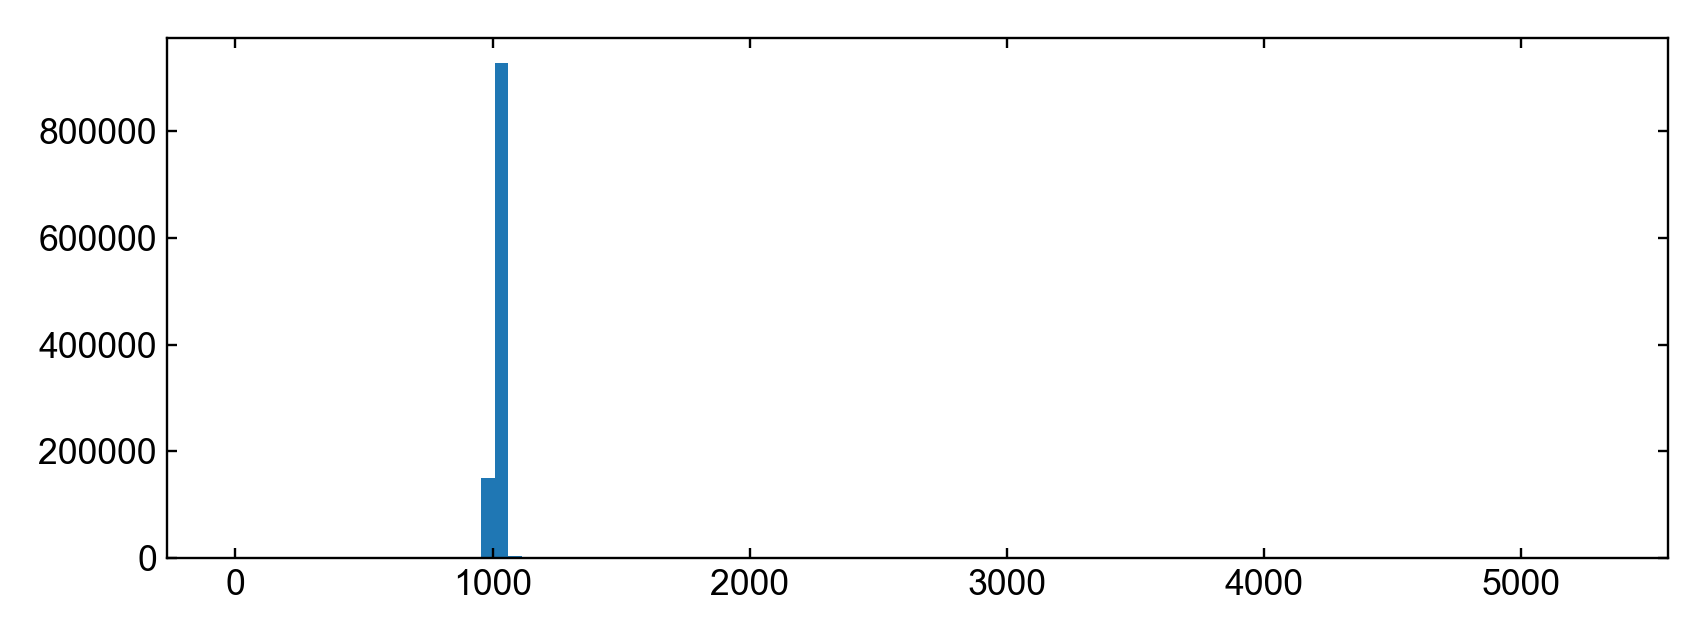

In [9]:
plt.figure(figsize=(8,3))
plt.hist(img_filt.ravel(), bins=100);

OK, it looks like all of our pixels are clumped around 900-1100. Let's take a look at the front end of this in detail - I happen to know this detector has ~990 count offset, but we should find that exactly.

<IPython.core.display.Javascript object>


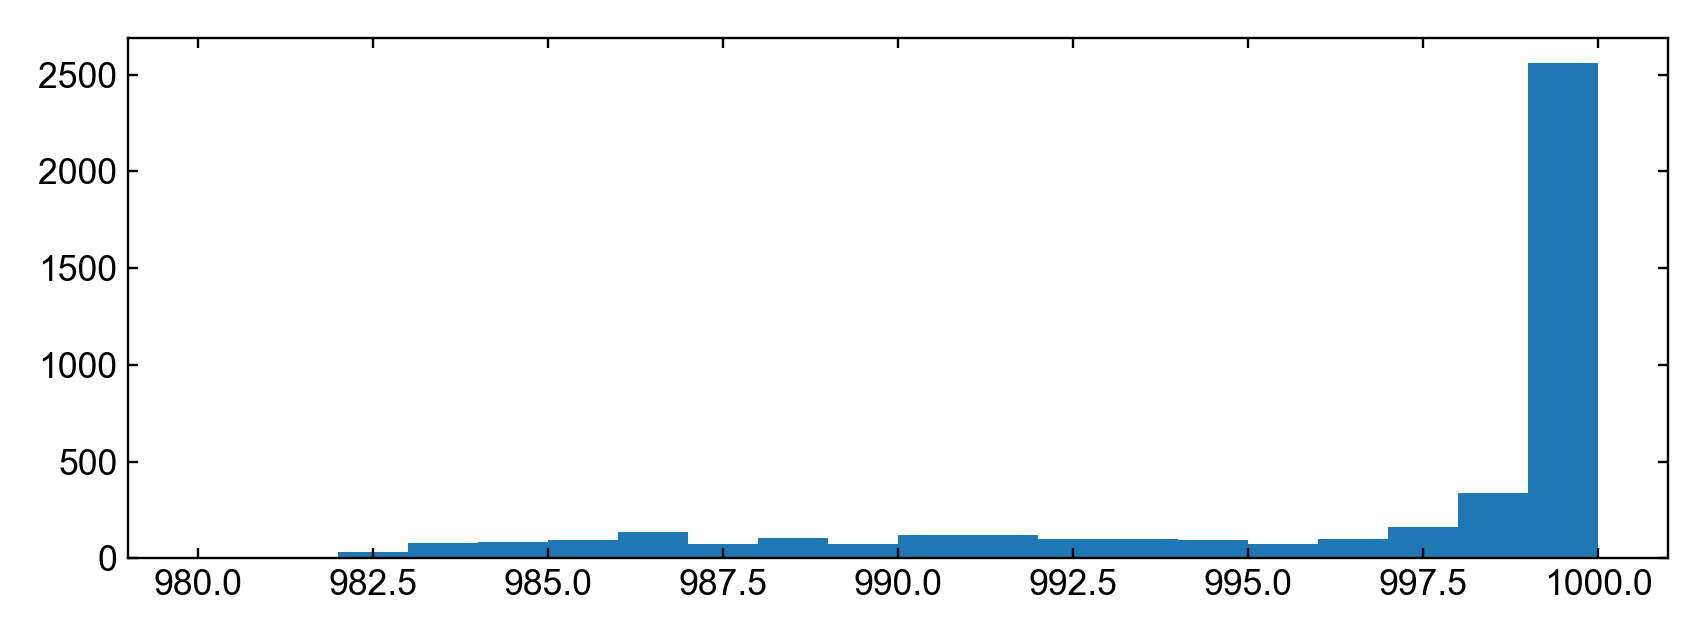

In [10]:
plt.figure(figsize=(8,3))
plt.hist(img_filt.ravel(), range=(980,1000), bins=20);

OK, looks like the offset is 980. Let's write a simple `get_data()` function that takes an image path and applies these basic pre-processing steps.

In [11]:
def get_waxs_data(tif_path, offset=980):
    raw = fabio.open(tif_path).data  # Load raw data
    filtered = medfilt(raw)  # De-zinger
    clipped = np.clip(filtered-offset, 0, None)  # Subtract offset and clip at 0
    return clipped

### `plt.imshow()` is the go-to image viewer.

You can ensure your x/y aspect ratio is 'equal', and it plots the array the way you would expect for an image, with y-indices increasing downward and x-indices increasing left-to-right. `%matplotlib notebook` gives it an automatic hover-tool to see raw values, and zoom-box functionality. We use `cmap='terrain'` because it has the most distinct color bands.

We can pass bounds on the colorbar as `vmin` and `vmax`, which I like to compute using `np.percentile()`.

<IPython.core.display.Javascript object>


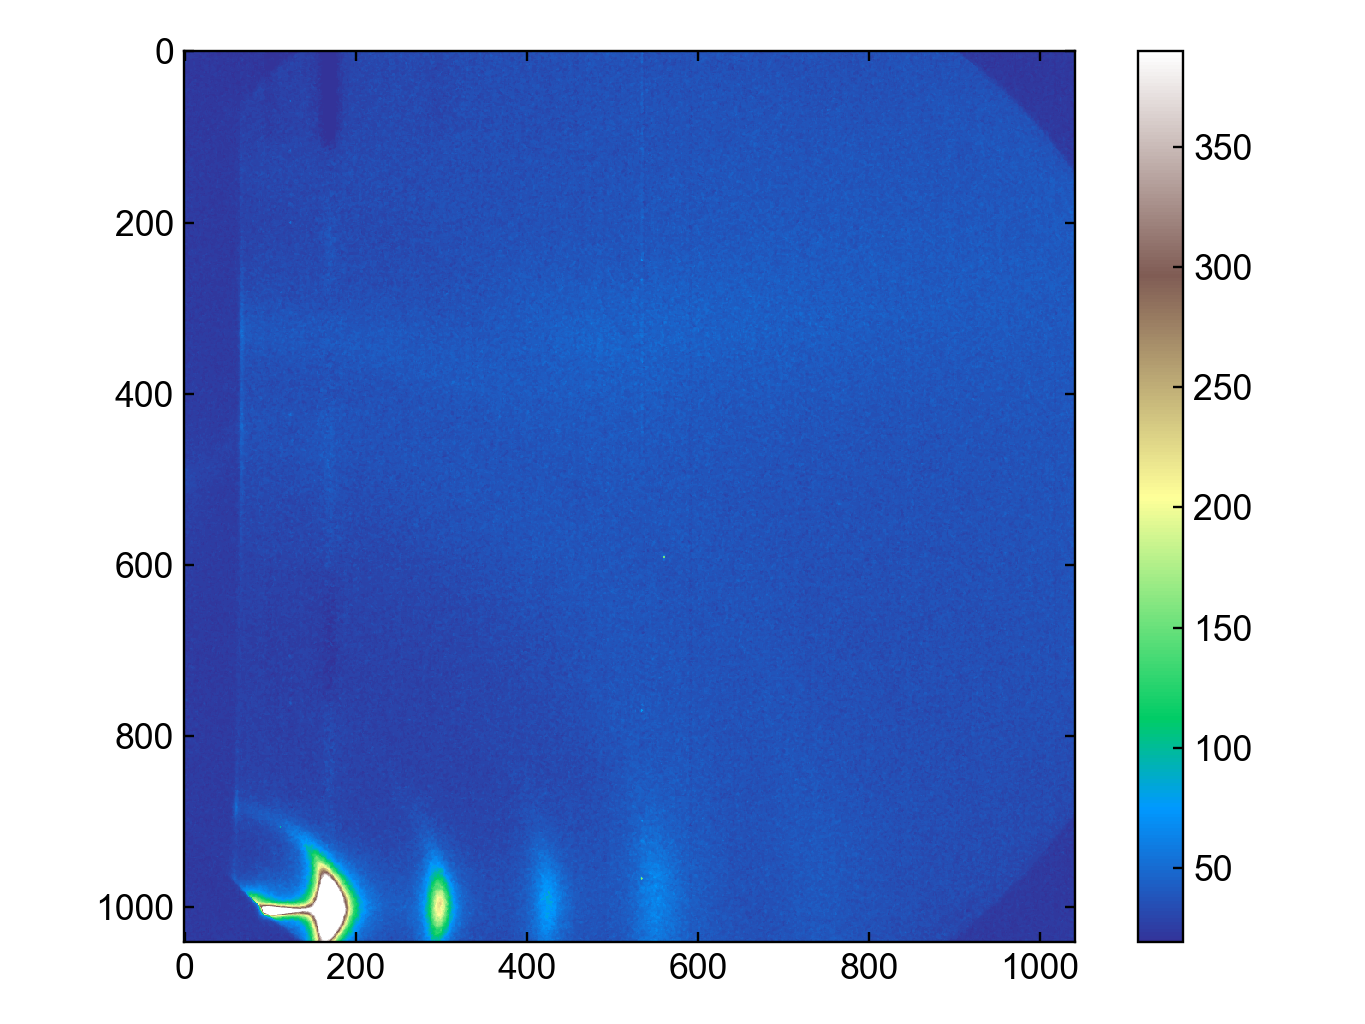

In [12]:
img = get_waxs_data(sample_file)  # Get the data array
vmin, vmax = np.percentile(img, (0.2, 99.8))
plt.figure()  # Create a figure
plt.imshow(img, cmap='terrain', aspect='equal', vmin=vmin, vmax=vmax)
plt.colorbar()

So there's our raw data! We can hover the mouse to look at individual pixel values and use the zoom-box tool to explore regions of interest. We could even throw in an `np.rot90()` to rotate it correctly, but that's actually something we should do in calibration, which is coming up next.

But first, this style of `imshow` is useful enough that I'd like to make a short function out of it. I would like to be able to use it in figures that have multiple plots, which means I need to be able to pass an `Axes` to it. The way I typically do this is by having an `ax=None` kwarg, so if I don't pass an Axes, it will make one itself, and if I do, it will plot on the one I pass in. This is also an easy way to hard-code our color mapping defaults.

In [14]:
def show_img(img, ax=None, prcs=(0.2, 99.8), cmap='terrain',
             aspect='equal', figsize=(5,4), extent=None, origin=None):
    
    if ax is None:   # If no axis was passed, make a new figure
        fig, ax = plt.subplots(figsize=figsize, tight_layout=False)
    plt.sca(ax)  # Set ax to the current axis for plt. commands
    
    vmin, vmax = np.percentile(img, prcs)   # Set min and max for color scale with percentiles
    plt.imshow(img, cmap=cmap, vmin=vmin, vmax=vmax,
               extent=extent, aspect=aspect, origin=origin)   # pass thru the kwargs for imshow
    plt.colorbar(fraction=0.045, pad=0.04)  # Necessary to make the colorbar same size as plot...

<IPython.core.display.Javascript object>


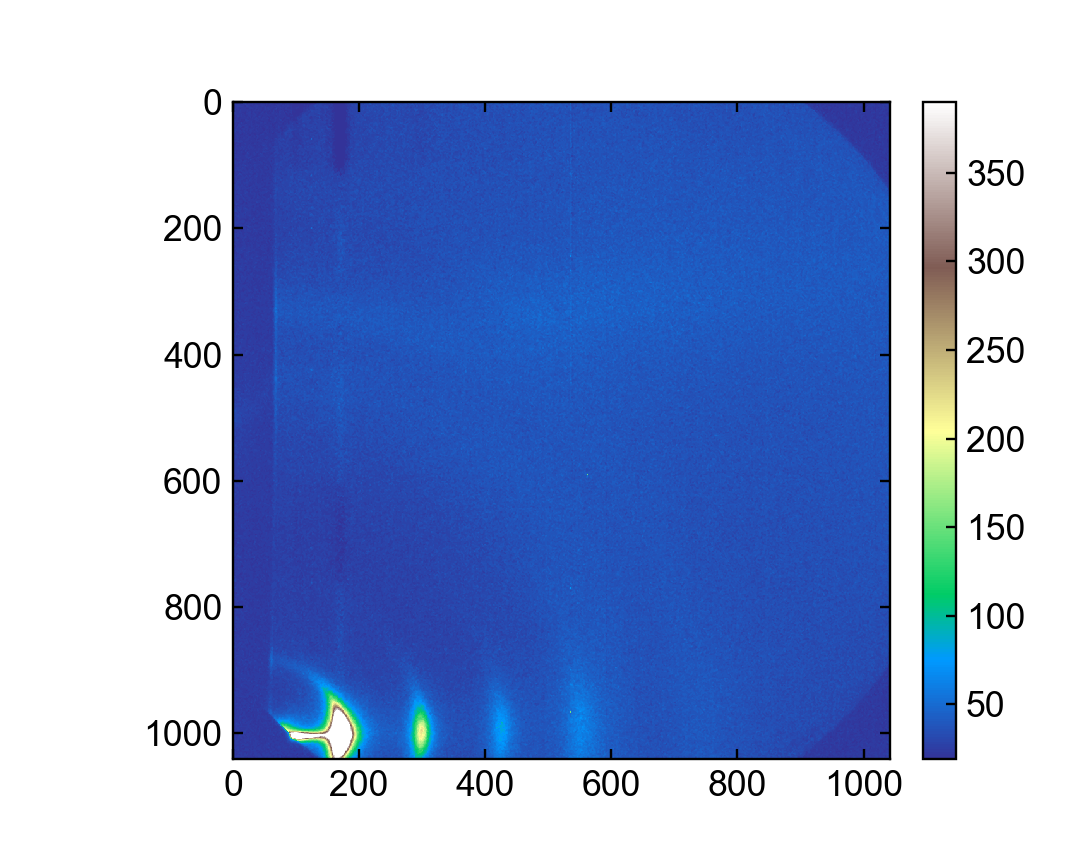

In [15]:
show_img(get_waxs_data(sample_file))

# 1. Calibration <a name='calib'></a>

Analysis of X-ray scattering patterns, once properly calibrated, is a rich subject in and of itself, with plenty of literature available. But calibrating an scattering pattern transformation (pixel space to momentum transfer space) is a rich subject *without* plenty of literature available.

### The meat of the problem is the following question: where was my detector relative to my sample?

## 1.0 Detectors <a name='det'></a>
---
[Back to TOC](#contents)

Answering this question requires a library that understands the geometry of detectors. [PyFAI](https://pyfai.readthedocs.io/en/latest/) is a remarkably fully-featured, GPU-compute-optimized library for the calibration, reduction and analysis of X-ray scattering patterns from many different detectors and modes. Over the coming tutorials, we will learn its innerworkings and examine practical use cases.

![pyfai](images/pyfai_geometry.png)

### From the [pyFAI documentation](https://pyfai.readthedocs.io/en/latest/geometry.html):

>With the detector being a rigid body, its position in space is described by six parameters: 3 translations and 3 rotations. In pyFAI, the beam center is not directly used as it is ill-defined with highly tilted detectors. Like SPD, we use the orthogonal projection of origin on the detector surface called PONI (for Point Of Normal Incidence). For non planar detectors, the PONI is defined in the plan z=0 in detector’s coordinate system.

>Poni1 and Poni2 are distances in meter (along the y and x axis of the detector), like the sample-detector distance, letting the calibration parameters be independent of the pixel size hence stable regarding the binning factor of the detector.

>In the same idea rot1, rot2 and rot3 are rotation along axis 1, 2 and 3, always expressed in radians. Rotations applied in the same order: rot1 then rot2 and finally rot3. Due to the axial symmetry of the Debye-Scherrer cones, rot3 cannot be optimized but can be adjusted manually in some cases like if the detector is not mounted horizontally and/or one cares about polarization correction.

### In pyFAI, an area detector is defined by its pixel width and height.

It actually has a number of detectors built-in!

In [16]:
import pyFAI
pyFAI.detectors.Pilatus300k()

Detector Pilatus 300k	 PixelSize= 1.720e-04, 1.720e-04 m

Looks like the Pilatus 300k has pixels that are $172 \times 172 \:\mu m$. For non-standard detectors, you can enter pixel size yourself:

In [17]:
pyFAI.detectors.Detector(100e-6,100e-6)

Detector Detector	 Spline= None	 PixelSize= 1.000e-04, 1.000e-04 m

### OK, we're done!

### Just kidding - now comes the hard part.

As seen in the image above, there are a few other parameters that we need to determine:
* energy / wavelength: this should have been provided by your beamline, or available in sample metadata
* `rot1`, `rot2`, `rot3`: detector rotations - your beamline may have provided these
* `PONI1`, `PONI2`: these are **NOT necessarily** the beam center - see above. PONI = Point of Normal Incidence. In the case where rot1=rot2=0, they may be equivalent. These will be fitted quantities.
* Sample-detector distance: the distance from the sample to the PONI. You should have a good guess for this, but it will also be fit.

### I'd like to stress that this is a *fitting* problem.

The calibration is a function that converts your raw image into a corrected image with corresponding axes in $q_{xy}$ and $q_z$. Your goal is to obtain this calibration. The parameters above are fitted model parameters, and the objective of the fitting procedure is to get a fake calibrant pattern to match the real one you collected. Some calibration tools will simplify this by fitting ring peaks, but these simplifications usually rule out more complicated detector geometries, and furthermore, add extra layers of data transformation that increase the likelihood of errors.

Here, we will take what I believe to be the most general (and visually intuitive) approach possible.

## 1.1 Calibrants <a name='rings'></a>
---
[Back to TOC](#contents)

pyFAI also contains a number of built-in calibrants. This means that it knows the peak locations in inverse space for a given calibrant material, and can simulate scattering patterns for that material and a given set of detector parameters.

In [18]:
from pyFAI import calibrant
pyFAI.calibrant.ALL_CALIBRANTS

Calibrants available: AgBh, Al, alpha_Al2O3, Au, C14H30O, CeO2, Cr2O3, cristobaltite, CrOx, CuO, LaB6, LaB6_SRM660a, LaB6_SRM660b, LaB6_SRM660c, mock, NaCl, Ni, PBBA, quartz, Si, Si_SRM640, Si_SRM640a, Si_SRM640b, Si_SRM640c, Si_SRM640d, Si_SRM640e, TiO2, ZnO

In [19]:
agbh = pyFAI.calibrant.get_calibrant('AgBh')
agbh.dSpacing[:5]

[58.38, 29.19, 19.46, 14.595, 11.676]

### We will need to give our calibrant a wavelength before it can do anything useful.

In [20]:
Energy = 11 #keV... This is in the calib_file name
wl = 3e8 * 6.63e-34 / Energy * 6.242e15 # c*h/Energy * keV/Joule = wavelength in meters
print('Wavelength =', wl, 'meters')
agbh._wavelength = wl   # Store the wavelength in the calibrant

Wavelength = 1.1286670909090908e-10 meters


### Now it can generate fake images; but we need the real ones to compare!

Let's load our `calib_file` and take a look at it.

<IPython.core.display.Javascript object>


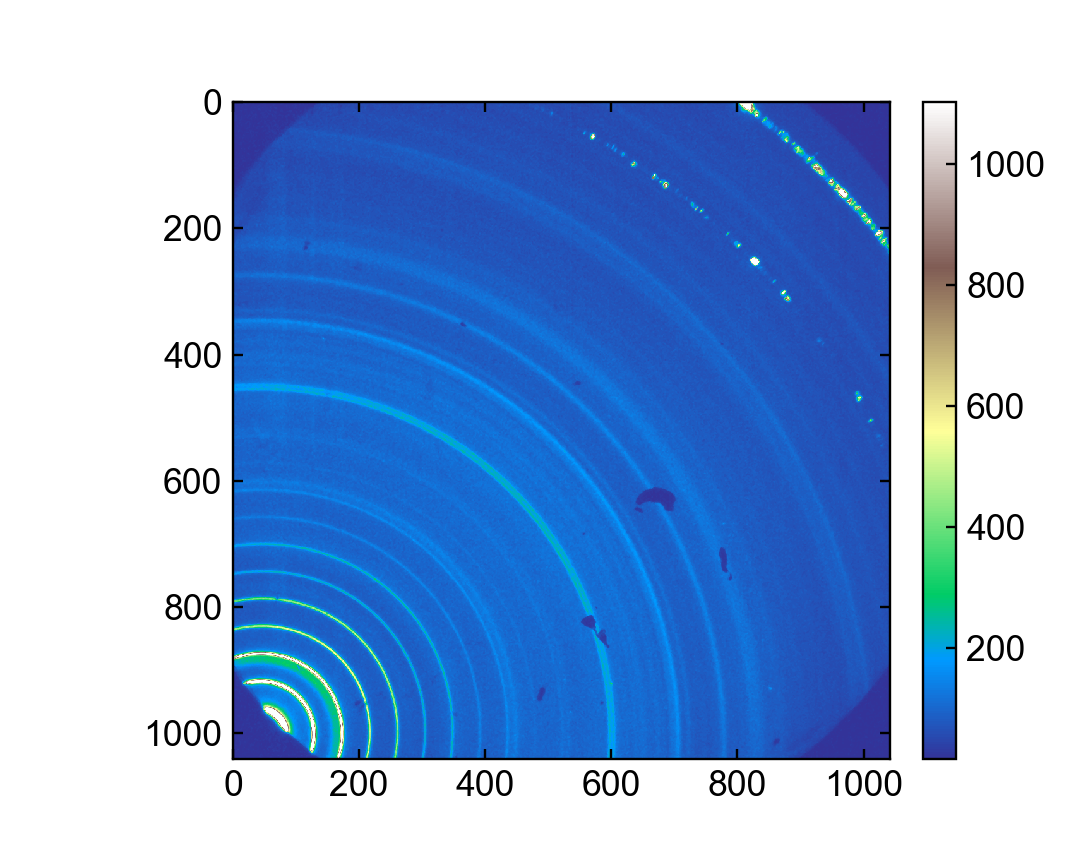

In [21]:
show_img(get_waxs_data(calib_file))

### That's the real calibration image; to generate a fake, we need to guess the detector params.

This is an odd detector; it's tilted by ~15 degrees in rot1 and rot2. I've chosen it specifically because it's a challenging calibration example. Per the discussion and figure above, this means the PONI is not necessarily the beam center. Let's assume the PONI is the center of the detector to start with: [550, 550]. Also, we can immediately tell that rot3 should be -90 from our sample image.

We will store all of these parameters in a dict, because they will soon get passed to a pyFAI object.

In [75]:
param_dict = {}

### From above
center_guess = [550, 550] # in pixel indices [y from top, x from left]

### Sample-detector distance (measure at beamline)
param_dict['dist'] = 0.19  # in meters - we know this approximately from the beamline

### Energy and Wavelength
Energy = 11 #keV... See table above
wl = 3e8 * 6.63e-34 / Energy * 6.242e15 # c*h/Energy * keV/Joule = wavelength in meters
param_dict['wavelength'] = wl

### Detector pixel size
det_pix = [101.7e-6, 101.7e-6] # We happen to know this as well
param_dict['detector'] = pyFAI.detectors.Detector(det_pix[0], det_pix[1])

### Convert center_guess into meters (pixel location * meters/pixel)
param_dict['poni1'] = center_guess[0]*det_pix[0]
param_dict['poni2'] = center_guess[1]*det_pix[1]

### Enter detector rotations (see figure above), if any
param_dict['rot1'] = 16.9    /180 * np.pi # move detector to right, in-plane angle in radians
param_dict['rot2'] = 12.7    /180 * np.pi # move detector up, out-of-plane angle
param_dict['rot3'] = -90   /180 * np.pi # clockwise rotation

param_dict

{'dist': 0.19,
 'wavelength': 1.1286670909090908e-10,
 'detector': Detector Detector	 Spline= None	 PixelSize= 1.017e-04, 1.017e-04 m,
 'poni1': 0.055935000000000006,
 'poni2': 0.055935000000000006,
 'rot1': 0.29496064358704166,
 'rot2': 0.22165681500327983,
 'rot3': -1.5707963267948966}

### Given these parameter guesses (that's all of them), we can now produce a fake image from our calibrant.

Let's re-define the calibrant here to alleviate scrolling.

In [76]:
agbh = pyFAI.calibrant.get_calibrant('AgBh')
agbh._wavelength = wl   # Store the wavelength in the calibrant
agbh

AgBh Calibrant at wavelength 1.1286670909090908e-10

### For pyFAI to generate an image, we need to define an "`AzimuthalIntegrator`"

This performs the necessary geometric transformations to make an image on the hypothetical detector we've defined by the parameter guesses. It's the central class in the pyFAI library, but we won't get into that now. We just pass the param_dict as *kwargs for this class. We also need to pass the shape (height and width) of the calibration image, and `W`, which specifies the width of the fake calibration peaks.

Here, we will take advantage of the fact that our `show_img()` function can take `ax` as an argument, and plot the real and fake images side-by-side. `plt.subplots()` returns `fig` and `axes`; `axes` is actually an array of two `Axes` objects, each of which can be passed to `show_img()`.

<IPython.core.display.Javascript object>


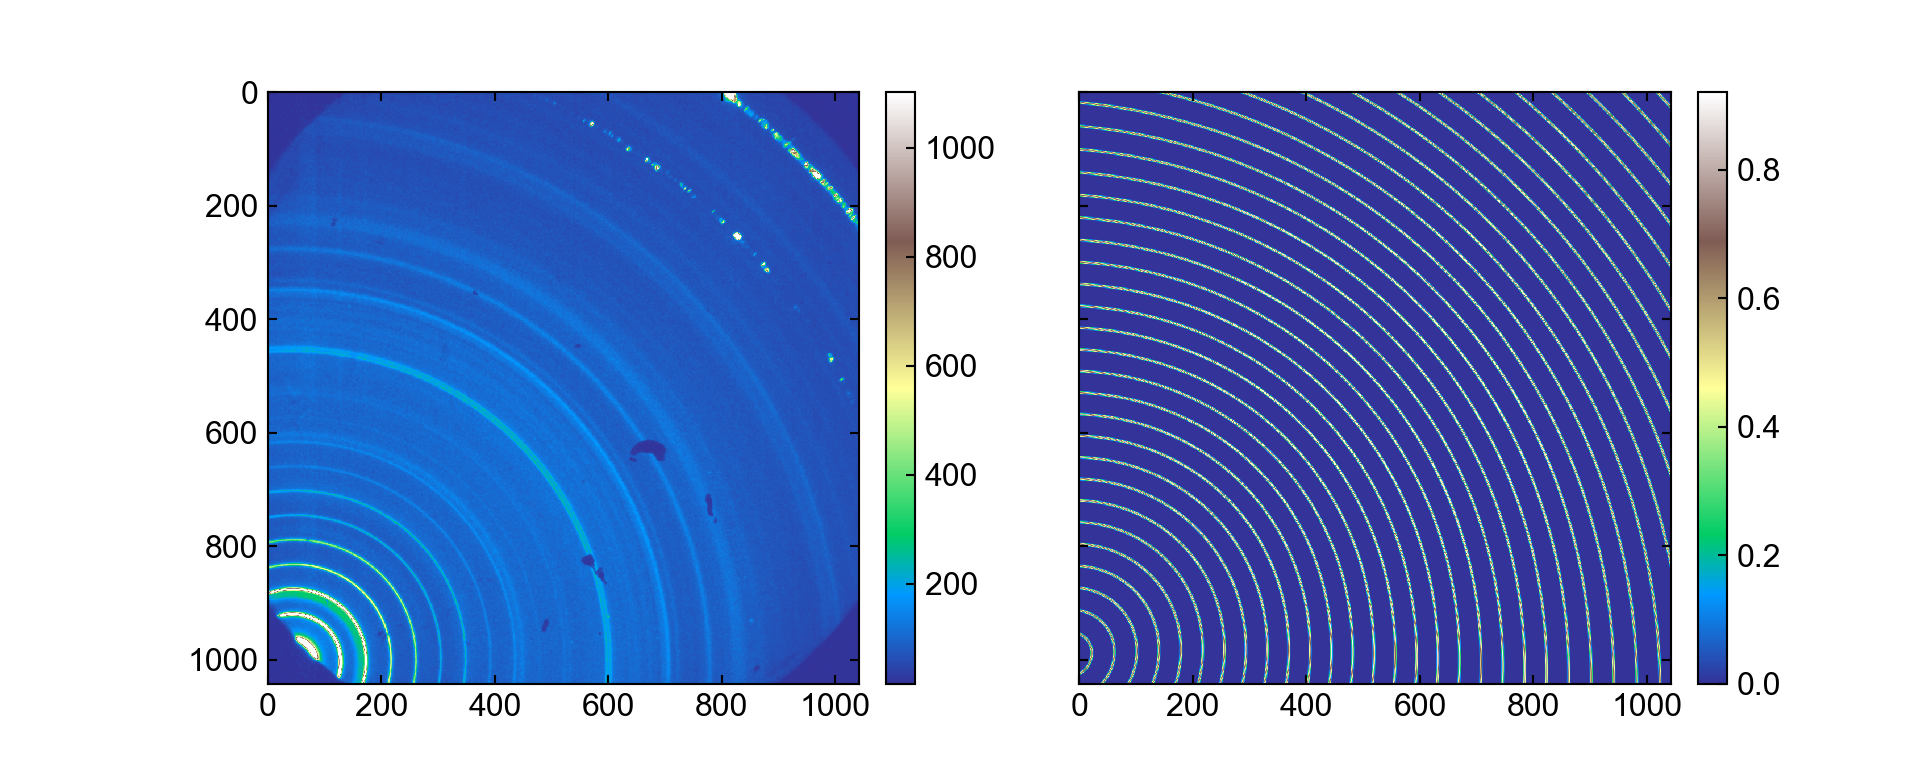

In [77]:
real = get_waxs_data(calib_file)

ai = pyFAI.AzimuthalIntegrator(**param_dict)
fake = agbh.fake_calibration_image(ai, shape=real.shape, W=2e-6) # W changes the width of the peaks

fig, axes = plt.subplots(1, 2, figsize=(10,4), sharex=True, sharey=True, tight_layout=False)
show_img(real, ax=axes[0])  # Plot real image
show_img(fake, ax=axes[1])  # Plot fake image

### Really, not a bad first guess. Now let's talk about how to turn this into an optimization problem.

## 1.2 The Fitting Problem <a name='fitting'></a>
---
[Back to TOC](#contents)

Like I said earlier, finding a good calibration is a fitting problem. We want to adjust:
* sample-detector distance
* PONI1 and PONI2
* Possibly rot1, rot2

until our fake and real rings overlap. Let's take a look at that cell with the side-by-side plots again, but this time with the adjustable parameters within sight. Try changing some of the parameters to see how it affects the fake image. I am immediately going to change my center_guess by -50 pixels in y to try and get the centers lined up better.

### Change the calibration parameters until your guess is visually good

In [91]:
param_dict = {}

### From above
center_guess = [550,550] # in pixel indices [y from top, x from left]

### Sample-detector distance (measure at beamline)
param_dict['dist'] = 0.19  # in meters

### Energy and Wavelength
Energy = 11 #keV... See table above
wl = 3e8 * 6.63e-34 / Energy * 6.242e15 # c*h/Energy * keV/Joule = wavelength in meters
param_dict['wavelength'] = wl

### Detector pixel size
det_pix = [101.7e-6, 101.7e-6] # We could have loaded the Pilatus, but this is easy enough
param_dict['detector'] = pyFAI.detectors.Detector(det_pix[0], det_pix[1])

### Convert center_guess into meters (pixel location * meters/pixel)
param_dict['poni1'] = center_guess[0]*det_pix[0]
param_dict['poni2'] = center_guess[1]*det_pix[1]

### Enter detector rotations (see figure above), if any
param_dict['rot1'] = 16.9    /180 * np.pi # move detector to right, in-plane angle in radians
param_dict['rot2'] = 12.7    /180 * np.pi # move detector up, out-of-plane angle
param_dict['rot3'] = -90   /180 * np.pi # clockwise rotation

<IPython.core.display.Javascript object>


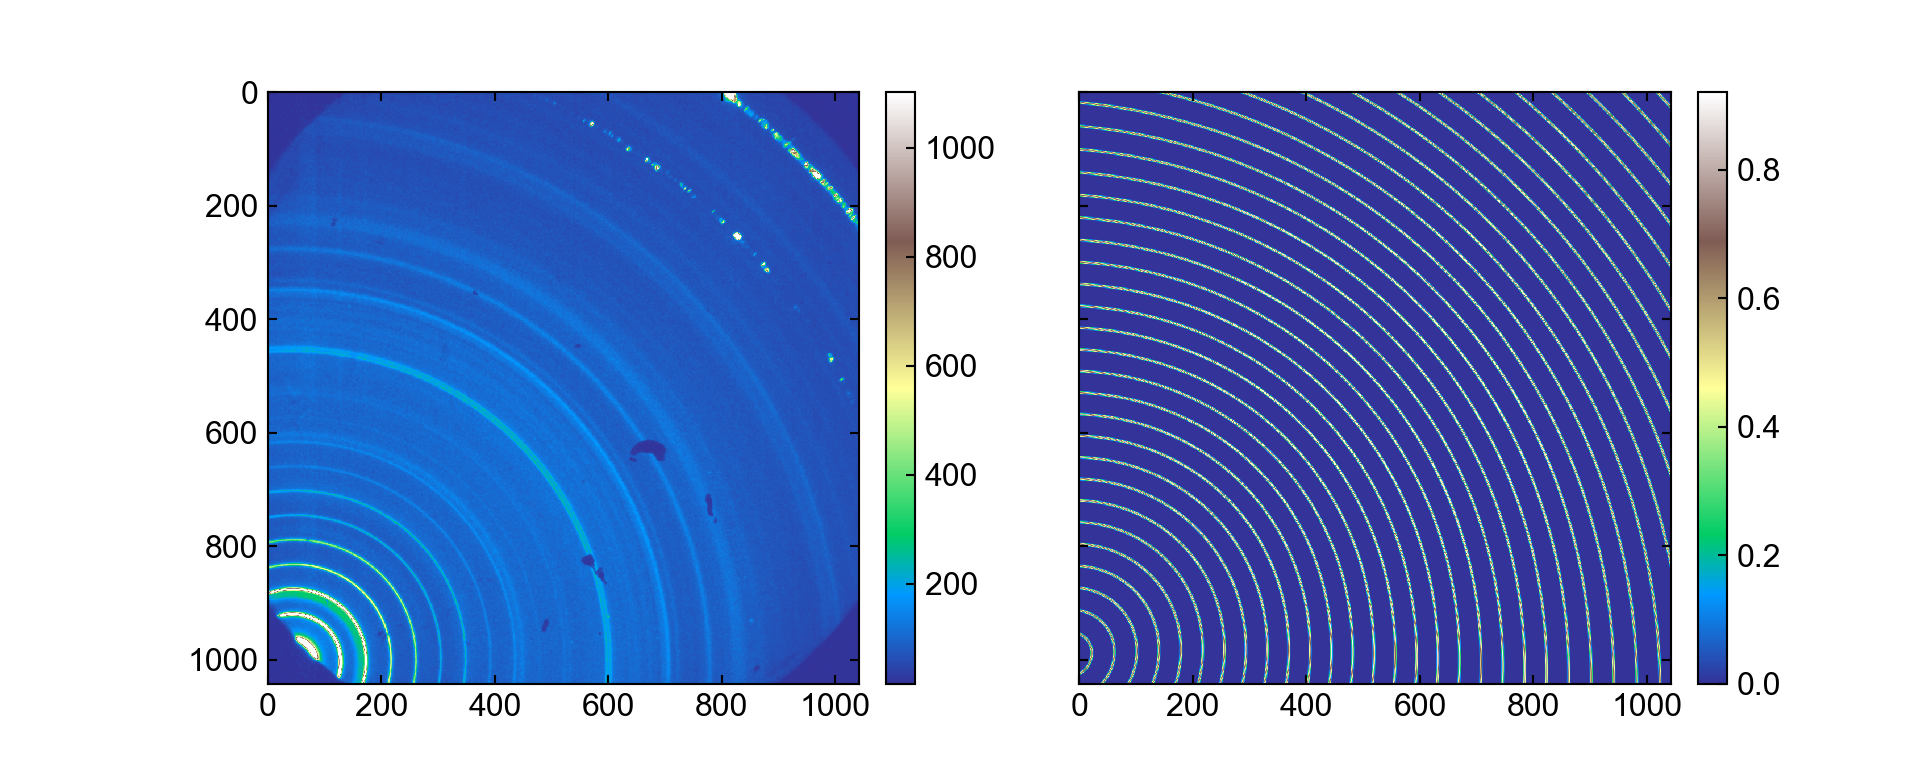

In [92]:
real = get_waxs_data(calib_file)

ai = pyFAI.AzimuthalIntegrator(**param_dict)
agbh = pyFAI.calibrant.get_calibrant('AgBh')
agbh._wavelength = wl   # Store the wavelength in the calibrant
fake = agbh.fake_calibration_image(ai, shape=real.shape, W=2e-6) # W changes the width of the peaks

fig, axes = plt.subplots(1, 2, figsize=(10,4), sharex=True, sharey=True, tight_layout=False)
show_img(real, ax=axes[0])  # Plot real image
show_img(fake, ax=axes[1])  # Plot fake image

### Finally, use the zoom-box tool to zoom in on a region where both the real and fake images have clear rings with no detector artifacts (bars, beamstop and the like).

This is called an ROI: Region of Interest.

We want to select an ROI where there are at least 2 visible rings, and where the rings have a good amount of curvature. The cool part about `%matplotlib notebook` is that after using the zoom-box tool to select an ROI, I can just grab the current axis limits using `.get_xlim()` or `.get_ylim()`. In this way, interactive matplotlib figures are great tools for selecting an ROI.

In [80]:
xl = np.round(axes[0].get_xlim()).astype(int)
yl = np.round(axes[0].get_ylim()).astype(int)[::-1]  # Gotta reverse this because it's backwards
print(xl, yl)

[192 351] [ 778 1035]


### We have our ROI, but now we want to maximize the "overlap" of these images

Every optimization problem needs a scalar-valued objective function. In this case, that's going to be the absolute difference in pixel intensities between the real and fake images, taken over all pixels.

There's just one problem: the scale of pixel intensities is vastly different for both images, as seen by the color bar scales. We should standardize that for both, which we can do by subtracting the mean and dividing by the std. Scipy also implements this as `.zscore`.

Finally, we can compute the "MAE" (mean of all the absolute differences between standardized pixel intensities) for the real/fake pair.

In [81]:
fake_roi = fake[yl[0]:yl[1], xl[0]:xl[1]]
real_roi = real[yl[0]:yl[1], xl[0]:xl[1]]

fake_roi_std = (fake_roi - np.mean(fake_roi)) / np.std(fake_roi)
real_roi_std = (real_roi - np.mean(real_roi)) / np.std(real_roi)

print(fake_roi_std.min(), fake_roi_std.max())
print(real_roi_std.min(), real_roi_std.max())

print('Mean diff:', np.mean(np.abs(fake_roi_std-real_roi_std), axis=(0,1)))

-0.35640030712630627 4.319213544212067
-1.210283474462174 7.613200706079984
Mean diff: 0.6635209641992637


### So our objective function will be to minimize the mean absolute difference (Mean Absolute Error) between the real and fake calibration images after cropping to an ROI and standardizing intensities.

This is a good Obj. Fun. because it should be scaled well between 0-1. Let's write a plotting function to visualize the objective, which will plot the real ROI, the fake ROI, and the magnitude of the difference between them.

In [82]:
def ofun_viz(real, fake, axes=None, err=None):
    
    if axes is None:
        fig, axes = plt.subplots(1, 3, figsize=(10,3), sharex=True, sharey=True)
    
    [ax.images.clear() for ax in axes] # Remove existing images so they don't accumulate
    
    err_array = np.abs(real-fake)
    axes[0].imshow(real, cmap='terrain')  # plot real image
    axes[1].imshow(fake, cmap='terrain')  # plot fake image
    axes[2].imshow(err_array, cmap='Reds')
    
    if err is None:
        err = np.mean(err_array, axis=(0,1))
    
    [a.set_title(t) for a,t in zip(axes, ['real', 'fake', 'err={}'.format(np.round(err,4))])]
    # Using a list comprehension to do things

<IPython.core.display.Javascript object>


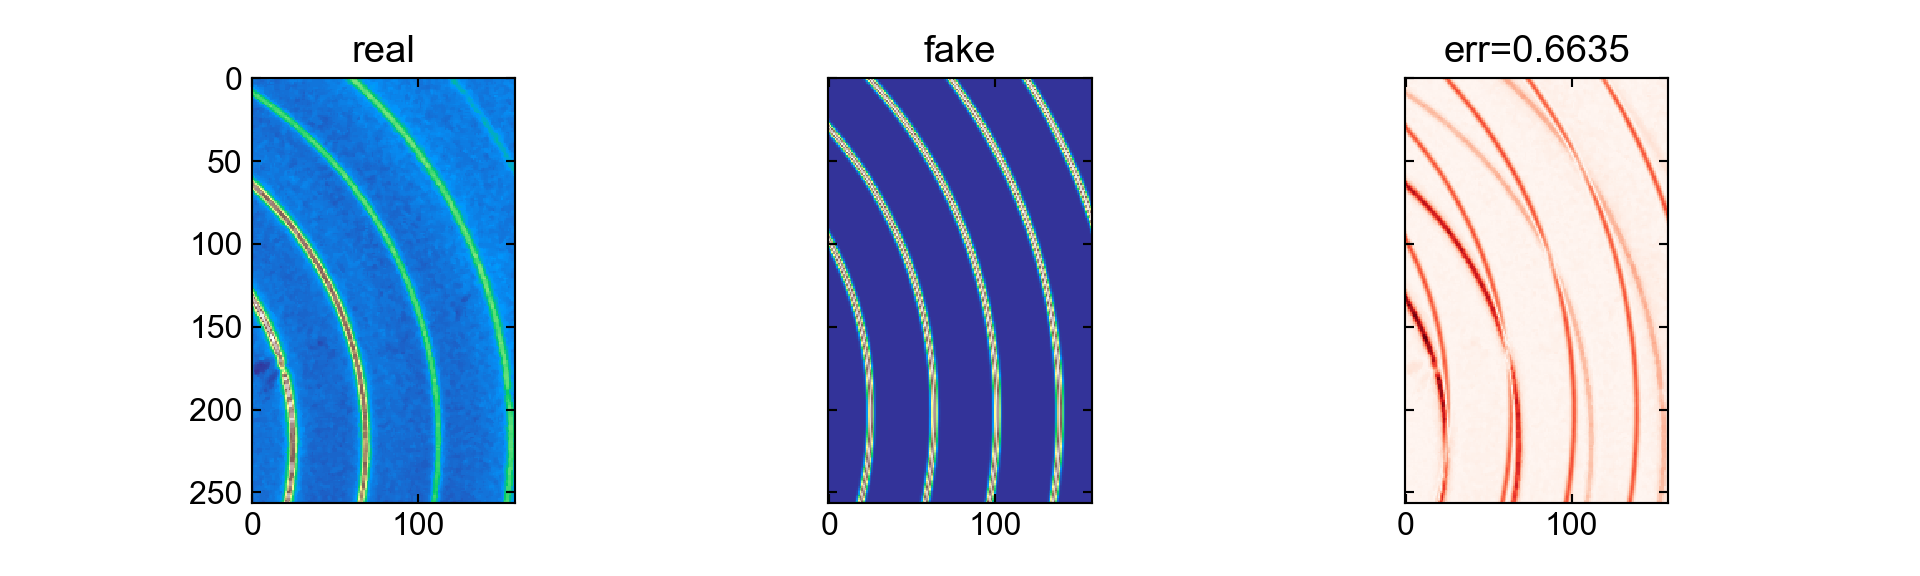

In [83]:
ofun_viz(real_roi_std, fake_roi_std)

The first ring (if it's visible) is generally very strong. I try to avoid putting the first ring in the optimization for this reason: it dominates the error term. However, this should still work. It's time to optimize.

## 1.3 Optimization in Python <a name='optim'></a>
---
[Back to TOC](#contents)

Crash course on optimization:
* You have an objective function that returns a scalar (preferably scaled between 0-1 with 0 being the target value)
* The objective function has adjustable parameters that you vary to affect the scalar output
* Optimization algorithms explore different values of the parameters to find the lowest value of the scalar output

Here, we will use [scipy.optimize](https://docs.scipy.org/doc/scipy/reference/optimize.html) - not the most powerful or fully-featured optimization library in history, but this should be a well-behaved convex function with a small search space (*i.e.* we have good initial guesses), so it'll be fine.

In [84]:
from scipy.optimize import minimize

### First, we have to define our objective function.

Generally, optimization libraries like the objective function to be in the form:

$f(X, other\:constant\:params...)$

where X is a vector containing the adjustable parameters: X will contain `[dist, poni1, poni2]`. I want a function that takes my current param_dict, writes an objective function, optimizes it, and gives me back the best param_dict. The inputs will be:

* param_dict
* the path to the real calibration image
* the calibrant
* (optionally) a list of `Axes` to plot the results in real-time
* (optionally) the x- and y-limits defining the ROI

And the output will be a `dict` with the same keys as `param_dict`, but with updated optimal values.

In [85]:
param_dict

{'dist': 0.19,
 'wavelength': 1.1286670909090908e-10,
 'detector': Detector Detector	 Spline= None	 PixelSize= 1.017e-04, 1.017e-04 m,
 'poni1': 0.055935000000000006,
 'poni2': 0.055935000000000006,
 'rot1': 0.29496064358704166,
 'rot2': 0.22165681500327983,
 'rot3': -1.5707963267948966}

### This cell breaks all my rules

In [88]:
def optimize_calibration(param_dict, real_calib_path, calibrant,
                         varied=['dist','poni1','poni2'],
                         axes=None, xl=[0,-1], yl=[0,-1], W=1e-6):
    
    # We want to do as much outside the obj_fun as possible (to minimize time per call)
    real = fabio.open(real_calib_path).data  # Open the real calibration image
    real_roi = real[yl[0]:yl[1], xl[0]:xl[1]]  # Crop to the ROI
    real_roi_std = (real_roi - np.mean(real_roi)) / np.std(real_roi)  # Standardize

    
    # Here we use an "inner function" to create our objective function
    def obj_fun(x, varied, param_dict_fixed):
        
        param_dict_varied = {k:v for k,v in zip(varied, x)} # Rebuild 'x' into arguments for the AI
        param_dict_full = {**param_dict_varied, **param_dict_fixed}  # This needs >=python3.5 I believe
        
        ai = pyFAI.AzimuthalIntegrator(**param_dict_full)  # Spin up the Azimuthal Integrator
        fake = agbh.fake_calibration_image(ai, shape = real.shape, W=W)  # Generate the fake image
        fake_roi = fake[yl[0]:yl[1], xl[0]:xl[1]]  # Crop to ROI
        fake_roi_std = (fake_roi - np.mean(fake_roi)) / np.std(fake_roi)  # Standardize
        
        err = np.mean(np.abs(fake_roi_std-real_roi_std), axis=(0,1))  # Calculate MAE
#         print('Residual: ', err)
        
        # Show results if we passed 'axes'
        if axes is not None:
            ofun_viz(real_roi_std, fake_roi_std, axes=axes, err=err)
            axes[0].figure.canvas.draw()
            plt.pause(0.2)
            
        return err
    
    
    # scipy.minimize needs an initial guess, so we take the 'varied' values of param_dict
    varied_params_init = [param_dict[k] for k in varied]  # Get just the values of the varied params
    param_dict_fixed = {k:v for k,v in param_dict.items() if k not in varied}  # dict.items() iterates through the key,value pairs
    args = (varied, param_dict_fixed)  # This needs to be the non-x arguments to obj_fun

    x_opt = minimize(obj_fun, varied_params_init,
                     args=args, method='nelder-mead', tol=1e-3,
                     options={'disp':True,
                              'maxiter':1000})
    
    param_dict_varied = {k:v for k,v in zip(varied, x_opt['x'])} # Rebuild 'x' into arguments for the AI
    final_param_dict = {**param_dict_varied, **param_dict_fixed}
    
    return final_param_dict

### Take some time to digest that.

There are a lot of advanced Python tricks there, like `dict` comprehensions, `**kwargs`, and inner functions. I made this really flexible for teaching purposes, and as a kind of challenge for myslef - it's not often that you write an optimization algorithm that updates an outside data visualization at every eval, or that can vary the number of parameters that it varies. I've tried to comment each line so it's clear what's going on.

But now, the cool part.

<IPython.core.display.Javascript object>


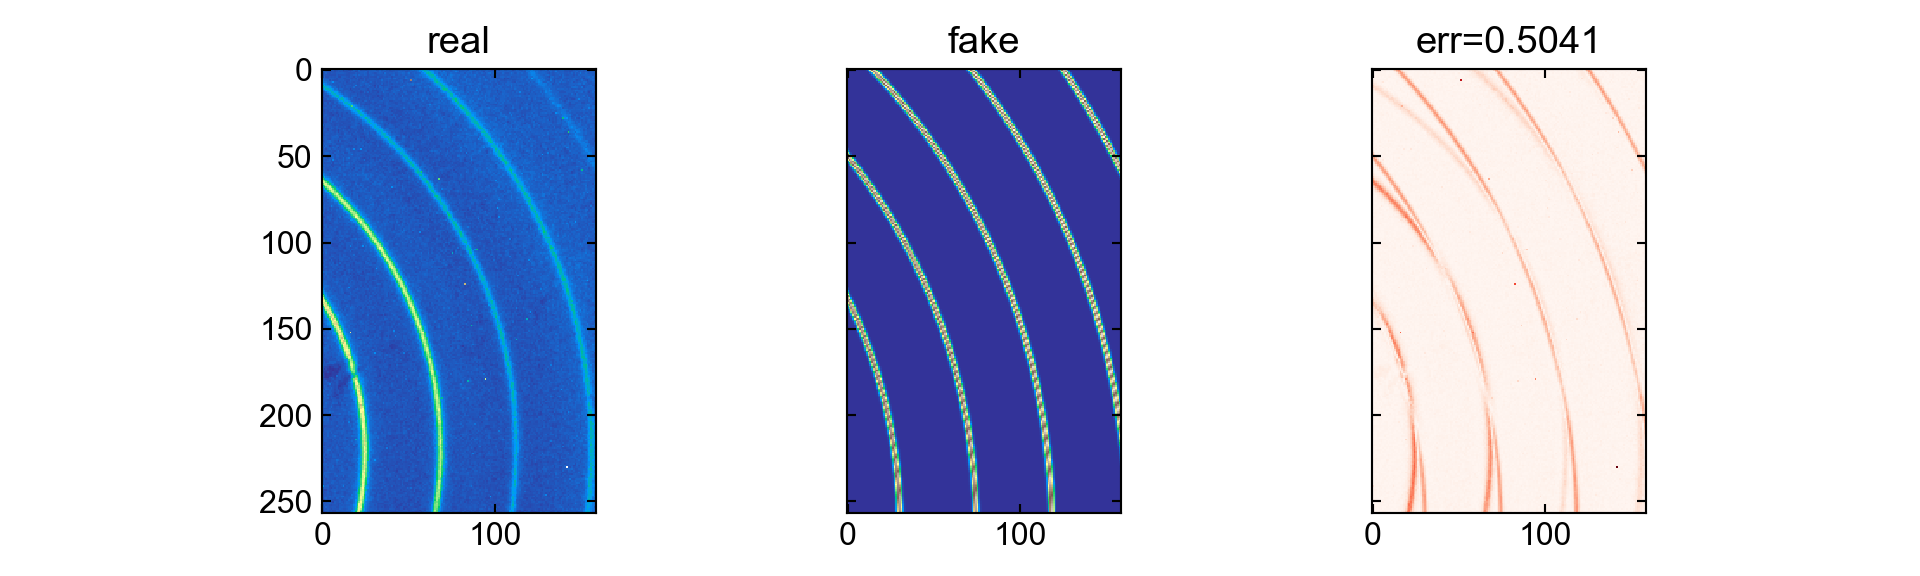

In [89]:
fig, axes = plt.subplots(1, 3, figsize=(10,3), sharex=True, sharey=True, tight_layout=False)

In [90]:
final_param_dict = \
    optimize_calibration(param_dict, calib_file, agbh,
                         varied=['dist','poni1','poni2'],
                         axes=axes, xl=xl, yl=yl)

Optimization terminated successfully.
         Current function value: 0.502739
         Iterations: 35
         Function evaluations: 67


NameError: name 'x_opt' is not defined

<IPython.core.display.Javascript object>


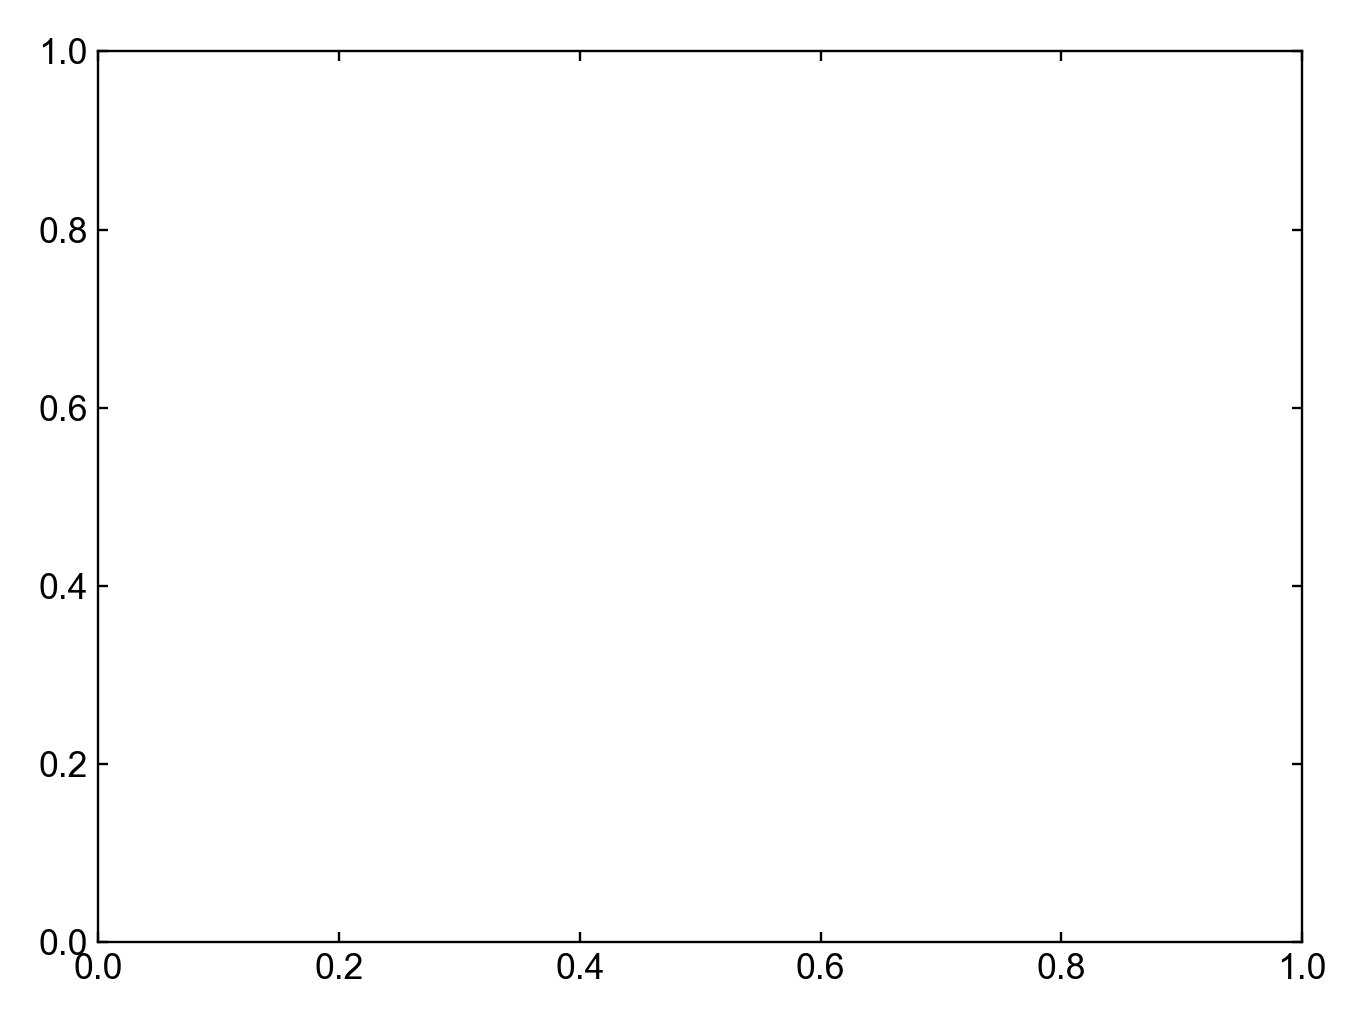

NameError: name 'real_roi_std' is not defined

In [49]:
%matplotlib notebook
fig, ax = plt.subplots()
# plt.ion()
# fig.show()
# fig.canvas.draw()
for im in [real_roi_std, fake_roi_std, real_roi_std, fake_roi_std]:
#     ax.clear()
    ax.imshow(im)
    fig.canvas.draw()
#     fig.show()
    plt.pause(1)

### Import python libraries

In [170]:
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

# numpy and plotting
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True,
                 'xtick.top': True,
                 'xtick.direction': 'in',
                 'ytick.right': True,
                 'ytick.direction': 'in',
                 'font.sans-serif': 'DejaVu Sans'
                })

from ipywidgets import interact

# Data handling
import glob
import os
import pandas as pd

# pyFAI
import pyFAI
from pyFAI.calibrant import get_calibrant
# from pyFAI.gui import jupyter

# pygix
import pygix
import fabio
from pygix import plotting as ppl

# Peak Fitting, optimization
from lmfit.models import GaussianModel, LorentzianModel, ExponentialModel, ConstantModel, LinearModel, VoigtModel
from scipy.optimize import minimize
from scipy.signal import medfilt

from nsls_utils_air import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load data files and dark spectra files

In [174]:
# data_dir = "\\\\cfs2e.nist.gov\\63_mml\\642\\users\\saxs8542\data\\NSLS-II CMS data\\2018-Dec\\Nils\\dead_vac"
nils_dir = "/Users/nils/CC/CMS Data/Nils/insitu_air"
sample_name = 'ds30cn_30_w1'
waxs_dir = os.path.join(nils_dir, sample_name, 'maxs')
waxs_files = glob.glob(os.path.join(waxs_dir, '*.tiff'))
print(waxs_files[0])

/Users/nils/CC/CMS Data/Nils/insitu_air/ds30cn_30_w1/maxs/ds30cn_30_w1_92.8s_th0.130_0.10s_994723_000000_maxs.tiff


## Master dataframe for actual data files

In [175]:
### build_master_table does a bunch of filename parsing in the background
dfw = build_master_table(waxs_files)
dfw.head()

tiff  burst  exp_time  mode  \
0  /Users/nils/CC/CMS Data/Nils/insitu_air/ds30cn...    0.0       0.1  maxs   
1  /Users/nils/CC/CMS Data/Nils/insitu_air/ds30cn...    1.0       0.1  maxs   
2  /Users/nils/CC/CMS Data/Nils/insitu_air/ds30cn...    2.0       0.1  maxs   
3  /Users/nils/CC/CMS Data/Nils/insitu_air/ds30cn...    3.0       0.1  maxs   
4  /Users/nils/CC/CMS Data/Nils/insitu_air/ds30cn...    4.0       0.1  maxs   

         sample   stamp     t  theta  
0  ds30cn_30_w1  994723  92.8   0.13  
1  ds30cn_30_w1  994723  92.8   0.13  
2  ds30cn_30_w1  994723  92.8   0.13  
3  ds30cn_30_w1  994723  92.8   0.13  
4  ds30cn_30_w1  994723  92.8   0.13

## Dataframe for calibration files

In [176]:
# data_dir = "\\\\cfs2e.nist.gov\\63_mml\\642\\users\\saxs8542\data\\NSLS-II CMS data\\2018-Dec\\Nils\\dead_vac"
calib_dir = "/Users/nils/CC/CMS Data/Nils/insitu_air/calib"
calib_files = glob.glob(os.path.join(calib_dir, '*.tiff'))
print(calib_files[0])
dfc = build_master_table(calib_files)
dfc['det'] = dfc['tiff'].apply(lambda s: os.path.basename(s).split('_')[-1].split('.')[0])
dfc

/Users/nils/CC/CMS Data/Nils/insitu_air/calib/AgBH_cali_12kev_106.1s_th0.171_1.00s_994875_saxs.tiff


tiff                  sample  \
0   /Users/nils/CC/CMS Data/Nils/insitu_air/calib/...         AgBH_cali_12kev   
1   /Users/nils/CC/CMS Data/Nils/insitu_air/calib/...         AgBH_cali_12kev   
2   /Users/nils/CC/CMS Data/Nils/insitu_air/calib/...         AgBH_cali_12kev   
3   /Users/nils/CC/CMS Data/Nils/insitu_air/calib/...         AgBH_cali_12kev   
4   /Users/nils/CC/CMS Data/Nils/insitu_air/calib/...         AgBH_cali_12kev   
5   /Users/nils/CC/CMS Data/Nils/insitu_air/calib/...         AgBH_cali_12kev   
6   /Users/nils/CC/CMS Data/Nils/insitu_air/calib/...         AgBH_cali_12kev   
7   /Users/nils/CC/CMS Data/Nils/insitu_air/calib/...         AgBH_cali_12kev   
8   /Users/nils/CC/CMS Data/Nils/insitu_air/calib/...         AgBH_cali_12kev   
9   /Users/nils/CC/CMS Data/Nils/insitu_air/calib/...         AgBH_cali_12kev   
10  /Users/nils/CC/CMS Data/Nils/insitu_air/calib/...  AgBH_cali_17.0keV_2.8m   
11  /Users/nils/CC/CMS Data/Nils/insitu_air/calib/...  AgBH_cali_17.0keV_2.8m   
12  /Users/nils/CC/CMS Data/Nils/insitu_air/calib/...  AgBH_cali_17.0keV_2.8m   
13  /Users/nils/CC/CMS Data/Nils/insitu_air/calib/...  AgBH_cali_17.0keV_2.8m   
14  /Users/nils/CC/CMS Data/Nils/insitu_air/calib/...  AgBH_cali_17.0keV_2.8m   
15  /Users/nils/CC/CMS Data/Nils/insitu_air/calib/...  AgBH_cali_17.0keV_2.8m   

        t  theta  exp_time   stamp  mode   det  
0   106.1  0.171       1.0  994875  saxs  saxs  
1   120.1  0.171       1.0  994876  saxs  saxs  
2   148.1  0.171       1.0  994877  saxs  saxs  
3   157.1  0.171       1.0  994878  saxs  saxs  
4   170.1  0.171       5.0  994879  saxs  saxs  
5   185.2  0.171       5.0  994880  maxs  maxs  
6    28.1  0.171       1.0  994871  saxs  saxs  
7    63.2  0.171       1.0  994872  saxs  saxs  
8    71.2  0.171       1.0  994873  saxs  saxs  
9    85.3  0.171       1.0  994874  saxs  saxs  
10  103.2  0.175       1.0  993892  maxs  maxs  
11  138.1  0.175      10.0  993893  maxs  maxs  
12  167.1  0.175      10.0  993894  saxs  saxs  
13  408.2  0.000      10.0  993895  saxs  saxs  
14   67.1  0.175       1.0  993890  maxs  maxs  
15   76.1  0.175       1.0  993891  maxs  maxs

## Calibration

In [177]:
calib_data = fabio.open(dfc.loc[5].tiff).data
calib_data.shape

2019-02-26 08:00:07,463 - fabio.TiffIO - WARNING - Data at tag id '65000' is smaller than expected


(619, 487)

<IPython.core.display.Javascript object>


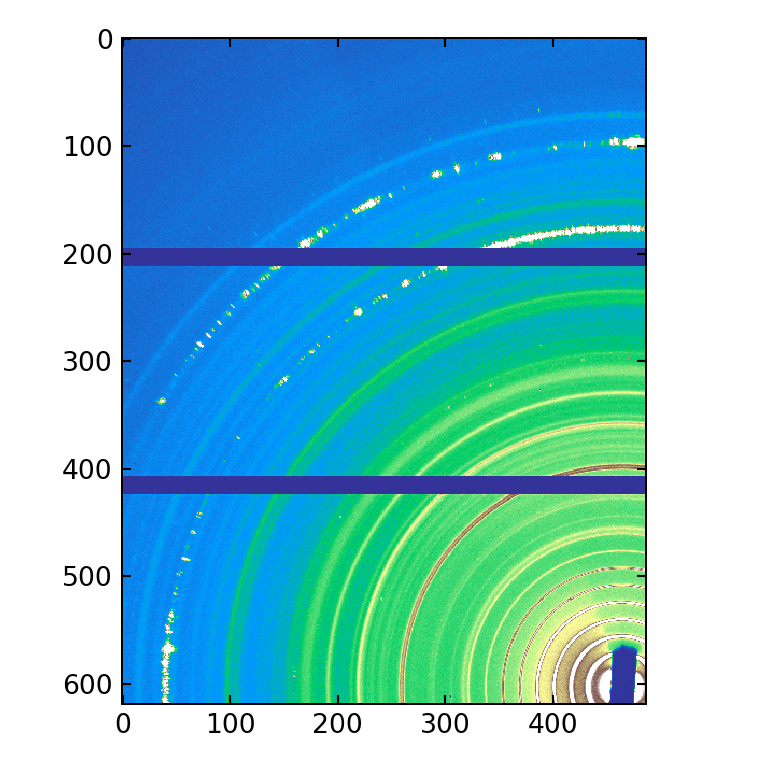

In [178]:
%matplotlib notebook

# det_shape = (619,487)

lmin, lmax = np.percentile(calib_data, (2, 99))
plt.figure(figsize=(4,4))
plt.imshow(calib_data, cmap='terrain',
           vmin=lmin, vmax=lmax,
           origin='upper')

### Beam center looks like [466, 603]

In [179]:
# NSLS-II is a photon Science CCD
# 17 keV for this calib image apparently
# nominally 190 mm

### Starting beam position
sdd_guess = 0.153
center_guess = [603, 466] # -y, +x

### Detector pixel size
det_pix = [172e-6, 172e-6]
detector = pyFAI.detectors.Detector(det_pix[0], det_pix[1])

### Wavelength
Energy = 12 #keV
wl = 3e8 * 6.63e-34 / Energy * 6.242e15 # c*h/Energy * keV/Joule = wavelength in meters

### Silver whatever calibrant
agbh = get_calibrant('AgBh')
agbh._wavelength = wl
vars(agbh)

{'_filename': '/anaconda/envs/pygix/lib/python3.6/site-packages/pyFAI/utils/../resources/calibration/AgBh.D',
 '_wavelength': 1.0346114999999999e-10,
 '_sem': <threading.Semaphore at 0x134e2ef28>,
 '_2th': [],
 '_dSpacing': []}

## Compare real calibration image to fake one

<IPython.core.display.Javascript object>


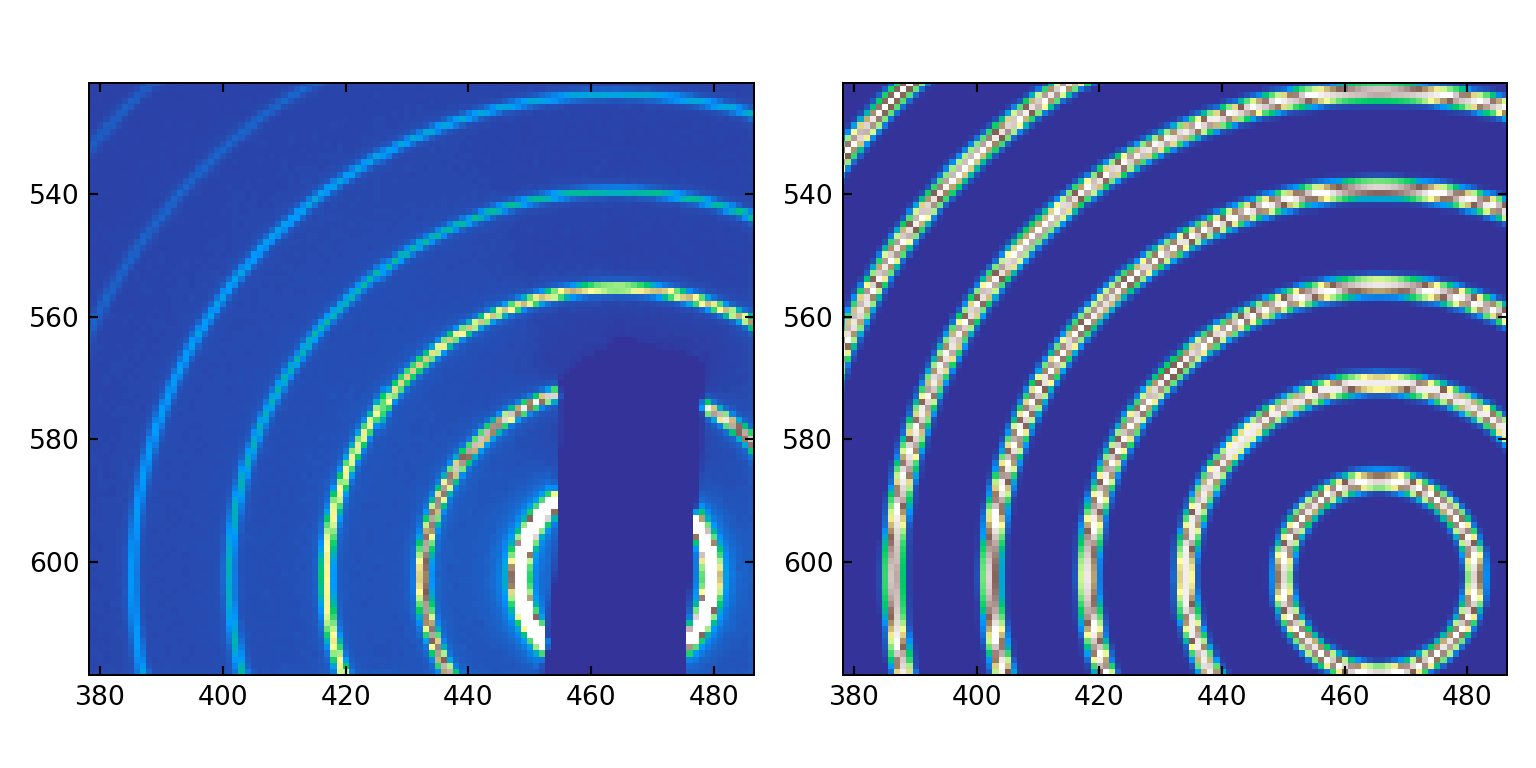

In [180]:
### Give initial guess of center location (in meters from the image origin i.e top left)
poni1_guess = center_guess[0]*det_pix[0]
poni2_guess = center_guess[1]*det_pix[1]

rot1 = 0    /180 * np.pi # move detector to right, in-plane angle# in radians
rot2 = 0    /180 * np.pi # move detector up, out-of-plane angle
rot3 = 0    /180 * np.pi # clockwise rotation

### Have to define an "azi integrator" then it can generate fake image of the calibrant
ai = pyFAI.AzimuthalIntegrator(dist=sdd_guess, poni1=poni1_guess, poni2=poni2_guess,
                               rot1=rot1, rot2=rot2, rot3=rot3,
                               detector=detector, wavelength=wl)
fake = agbh.fake_calibration_image(ai, shape = calib_data.shape, W=0.000005)

### Plot the real calibration image next to fake one
cmin, cmax = np.percentile(fake, (2, 99.9))
lmin, lmax = np.percentile(calib_data, (10, 99.9))

plt.figure(figsize=(8,4))
ax1=plt.subplot(122)
plt.imshow(fake, cmap='terrain',
           vmin=cmin, vmax=cmax,
           origin='upper')
ax2=plt.subplot(121, sharex=ax1, sharey=ax1)
plt.imshow(calib_data, cmap='terrain',
           vmin=lmin, vmax=lmax,
           origin='upper')
# plt.savefig('calib_debug\\rings.png')

## Write down coordinates of mask by zooming in on a ring section with a flat-ish background

In [181]:
mask_bounds = [525,575,390,440] # indices of a box around a ring sector: [i-, i+, j-, j+]
fg_int=8000; bg_int=1000 # approximate ring intensity, approximate bg intensity - read from graph above
fake_ring_int = 0.9; fake_bg_int = 0
scale_init = [(fg_int-bg_int)/(fake_ring_int-fake_bg_int), bg_int-(fg_int-bg_int)/(fake_ring_int-fake_bg_int)*fake_bg_int]

In [182]:
scale_init

[7777.777777777777, 1000.0]

## Define an optimizer that will fit a fake ring to a real ring
Looks like we should target the first ring, so we need to define mask bounds so we don't try to fit every ring

In [184]:
from datetime import datetime

def calib_obj_fun(x, calib_img, detector, calibrant, bb, wl, scale, W, rot1, rot2, rot3):
    
    # x: [beam_cent_y, beam_cent_x, sdd, fake_scale]
    # bb is mask bounds [-i, +i, -j, +j]
#     print(x.shape)
    
    # Set up test detector
    det_shape=calib_img.shape
    poni1 = x[0]*detector.get_pixel1()
    poni2 = x[1]*detector.get_pixel2()
    ai = pyFAI.AzimuthalIntegrator(dist=x[2], poni1=poni1, poni2=poni2,
                                   rot1=x[3], rot2=x[4], rot3=rot3,
                                   detector=detector, wavelength=wl)
    
    # Generate fake calibrant image, apply scale and background
    fake = calibrant.fake_calibration_image(ai, shape = det_shape, W=W) * scale[0] + scale[1]

    # Return the sum of the ABSOLUTE difference
    out = np.sum(np.sum(np.abs(calib_img-fake)[bb[0]:bb[1],bb[2]:bb[3]]))
    print('Residual: {}'.format(out))
    return out

def calibrate_waxs(calib_img, detector, calibrant, cent_init, sdd_init, scale_init, wl, mask_bounds,
                   rot1, rot2, rot3, W=0.000005):
    
    init_params = [cent_init[0], cent_init[1], sdd_init, rot1, rot2]
    
    args = (calib_img, detector, calibrant, mask_bounds, wl, scale_init, W, rot1, rot2, rot3)

    final_params = minimize(calib_obj_fun, init_params,
                            args=args, method='nelder-mead', tol=1e-3,
                            options={'disp':True,
                                     'maxiter':1000})
    
    return final_params

In [185]:
det_params = calibrate_waxs(calib_data, detector, agbh, center_guess, sdd_guess, scale_init, wl, mask_bounds,
                            rot1, rot2, rot3)
det_params

Residual: 2127581.6379787647
Residual: 3713080.841240162
Residual: 3205108.9478041288
Residual: 3450813.3142229393
Residual: 2066314.6346239785
Residual: 2195856.0162911825
Residual: 3212125.728126965
Residual: 3582382.5245143976
Residual: 2509461.0807264876
Residual: 3735978.0367388204
Residual: 3285768.1281793118
Residual: 2093454.4276951544
Residual: 2118199.8921410604
Residual: 2131756.6028361483
Residual: 3707869.439560118
Residual: 3544083.583919305
Residual: 3679812.928162992
Residual: 3717551.9709701436
Residual: 2079261.4862225447
Residual: 2089967.0968251922
Residual: 2032908.9232767234
Residual: 3340390.8688339395
Residual: 3649298.6185769793
Residual: 3744247.6840257193
Residual: 3091988.380199587
Residual: 3697517.58369999
Residual: 2680353.935518212
Residual: 3161479.98958458
Residual: 2501191.905634217
Residual: 3383491.8002712494
Residual: 2151184.30794113
Residual: 2030477.6392935633
Residual: 2610788.9775789124
Residual: 2273479.1602028883
Residual: 1989666.0634123648

 final_simplex: (array([[6.03317955e+02, 4.64537373e+02, 1.52394811e-01, 2.33302778e-04,
        3.42113209e-05],
       [6.03317952e+02, 4.64537369e+02, 1.52394808e-01, 2.33301575e-04,
        3.42095019e-05],
       [6.03317951e+02, 4.64537368e+02, 1.52394802e-01, 2.33301343e-04,
        3.42095274e-05],
       [6.03317955e+02, 4.64537366e+02, 1.52394809e-01, 2.33301382e-04,
        3.42093528e-05],
       [6.03317950e+02, 4.64537370e+02, 1.52394808e-01, 2.33301069e-04,
        3.42088527e-05],
       [6.03317953e+02, 4.64537367e+02, 1.52394801e-01, 2.33301547e-04,
        3.42099528e-05]]), array([1948266.24754824, 1948266.24775662, 1948266.24788332,
       1948266.24797092, 1948266.24834257, 1948266.24845458]))
           fun: 1948266.247548245
       message: 'Optimization terminated successfully.'
          nfev: 282
           nit: 146
        status: 0
       success: True
             x: array([6.03317955e+02, 4.64537373e+02, 1.52394811e-01, 2.33302778e-04,
       3.42113209e-

## Finally, build a detector based on the fitted parameters

In [186]:
dfw.loc[904]

tiff        /Users/nils/CC/CMS Data/Nils/insitu_air/ds30cn...
burst                                                     NaN
exp_time                                                   10
mode                                                     maxs
sample                                      ds30cn_30_w1_pos1
stamp                                                  994732
t                                                       272.8
theta                                                    0.15
Name: 904, dtype: object

## Try a transform, see how it works

2019-02-26 08:03:47,098 - fabio.TiffIO - WARNING - Data at tag id '65000' is smaller than expected


<IPython.core.display.Javascript object>


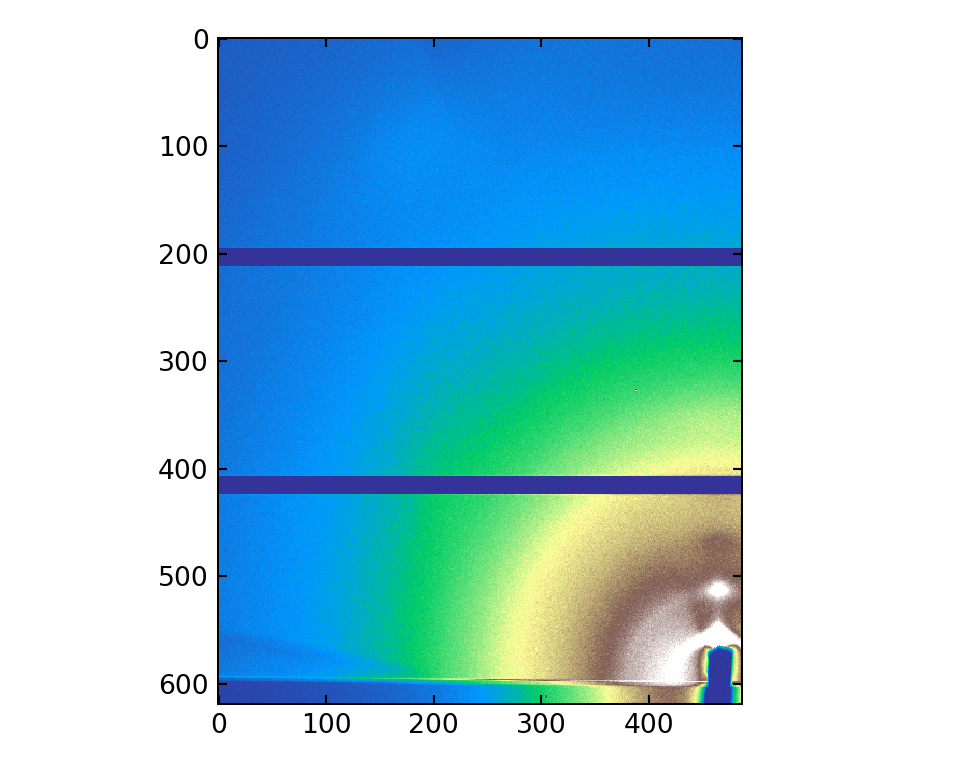

In [187]:
sample = 904

pcolor(get_data(dfw,sample), aspect='equal')

## Dump detector params to a csv

In [188]:
# Orientations and Angles
sample_orientation = 1    # 1 is horizontal, 2 is vertical
tilt_angle = 0            # tilt angle of sample in deg (misalignment in "chi")

### poni1 is the y-coordinate (in meters) on the detector where the beam hits.
### poni2 is same for x. So we take the fitted beam center in pixels and multiply by the pixel size
det_param_dict = {'det_pix': det_pix[0],
                  'wavelength': wl,
                  'poni1': det_params.x[0] * det_pix[0],
                  'poni2': det_params.x[1] * det_pix[1],
                  'dist': det_params.x[2],
                  'rot1': det_params.x[3],
                  'rot2': det_params.x[4],
                  'rot3': 180 / 180 *np.pi,
                  'sample_orientation': sample_orientation,
                  'tilt_angle': tilt_angle}

det_param_df = pd.DataFrame(det_param_dict, index=['val']).transpose().reset_index().rename(columns={'index':'param'})
det_param_df.to_csv(os.path.join(nils_dir,'calib.csv'))

In [189]:
det_param_df = pd.read_csv(os.path.join(nils_dir,'calib.csv'))
det_kwargs = dict(zip(det_param_df['param'], det_param_df['val']))
det_kwargs

{'det_pix': 0.000172,
 'dist': 0.1523948111643043,
 'poni1': 0.10377068826819774,
 'poni2': 0.07990042810956673,
 'rot1': 0.000233302777589545,
 'rot2': 3.421132088879312e-05,
 'rot3': 3.1415926535897927,
 'sample_orientation': 1.0,
 'tilt_angle': 0.0,
 'wavelength': 1.0346115e-10}

2019-02-26 08:04:01,288 - fabio.TiffIO - WARNING - Data at tag id '65000' is smaller than expected
2019-02-26 08:04:01,341 - fabio.TiffIO - WARNING - Data at tag id '65000' is smaller than expected
2019-02-26 08:04:01,402 - pygix.transform - INFO - pygix.Transform.transform_image: Resetting transformer because init


<IPython.core.display.Javascript object>


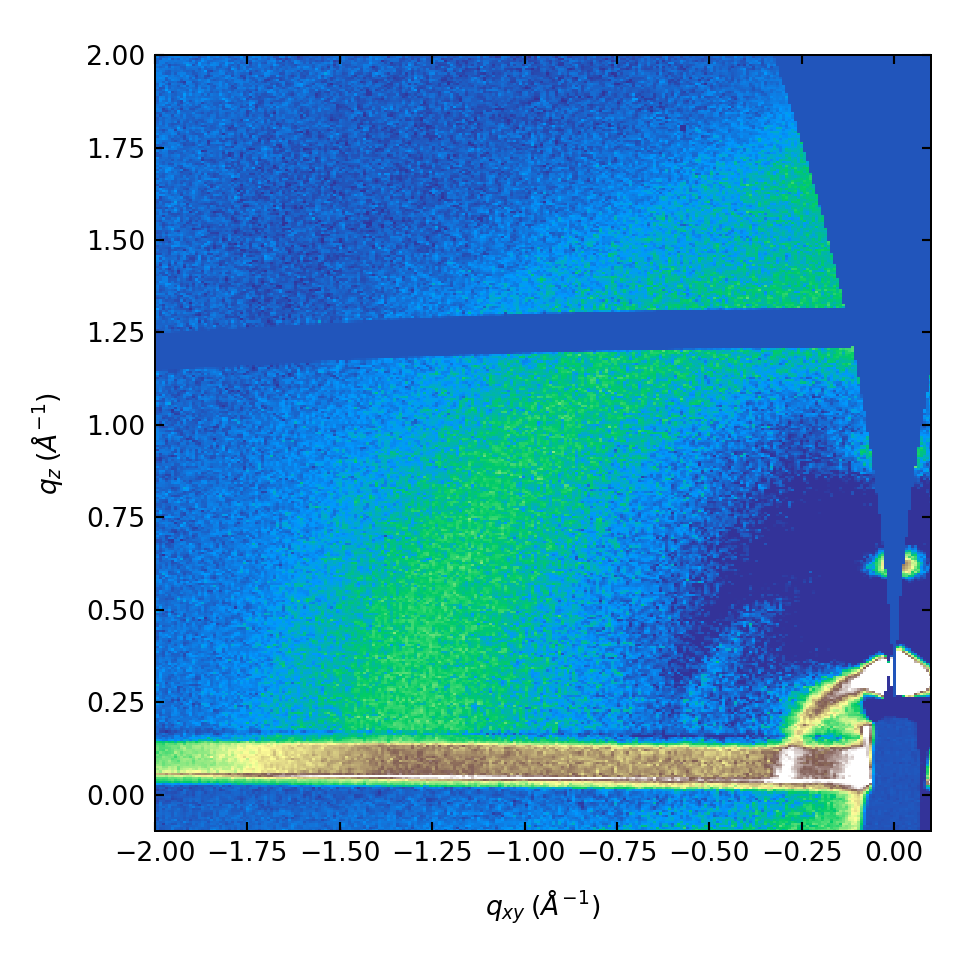

/anaconda/envs/pygix/lib/python3.6/site-packages/pygix-0.1.4a0-py3.6.egg/pygix/plotting.py:346: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif clim == 'auto':


(<matplotlib.image.AxesImage at 0x13082ce10>,
 <matplotlib.axes._subplots.AxesSubplot at 0x13958b588>)

In [190]:
pg = setup_detector(dfw['theta'].loc[sample], os.path.join(nils_dir,'calib.csv'))
imgt, qxy, qz = pg.transform_reciprocal(get_data(dfw,sample), method='lut',
                                        correctSolidAngle=True, unit='A',
                                        dark=get_blank(dfb, dfw, sample, blank_set='test_si'))
corrimg = imgt-np.min(imgt)+1
logimg = np.log(corrimg)

clim = np.percentile(logimg[logimg>1], (2, 99.8))
plt.figure(figsize=(5,5))
ppl.implot(logimg, qxy, qz, mode='rsma',
           cmap="terrain", clim=clim,
           xlim=(-2,0.1), ylim=(-0.1,2),
           newfig=False)

In [191]:
def get_pole_figure(df, sample, calib_csv, chi_range=(-90,0), q_range=(0,2), npt=(180,180)):
    
    data = get_data(df, sample)
    theta = df.loc[sample].theta
    pg = setup_detector(theta, calib_csv)
    print(data.shape)
    
    intensity, q_abs, chi = pg.transform_polar(data, unit='A',
                                               npt=npt,
                                               chi_range=chi_range, q_range=q_range,
                                               correctSolidAngle=True,
                                               method='splitpix')
    
    return intensity, q_abs, chi

2019-02-26 08:04:20,224 - fabio.TiffIO - WARNING - Data at tag id '65000' is smaller than expected


(619, 487)


<IPython.core.display.Javascript object>


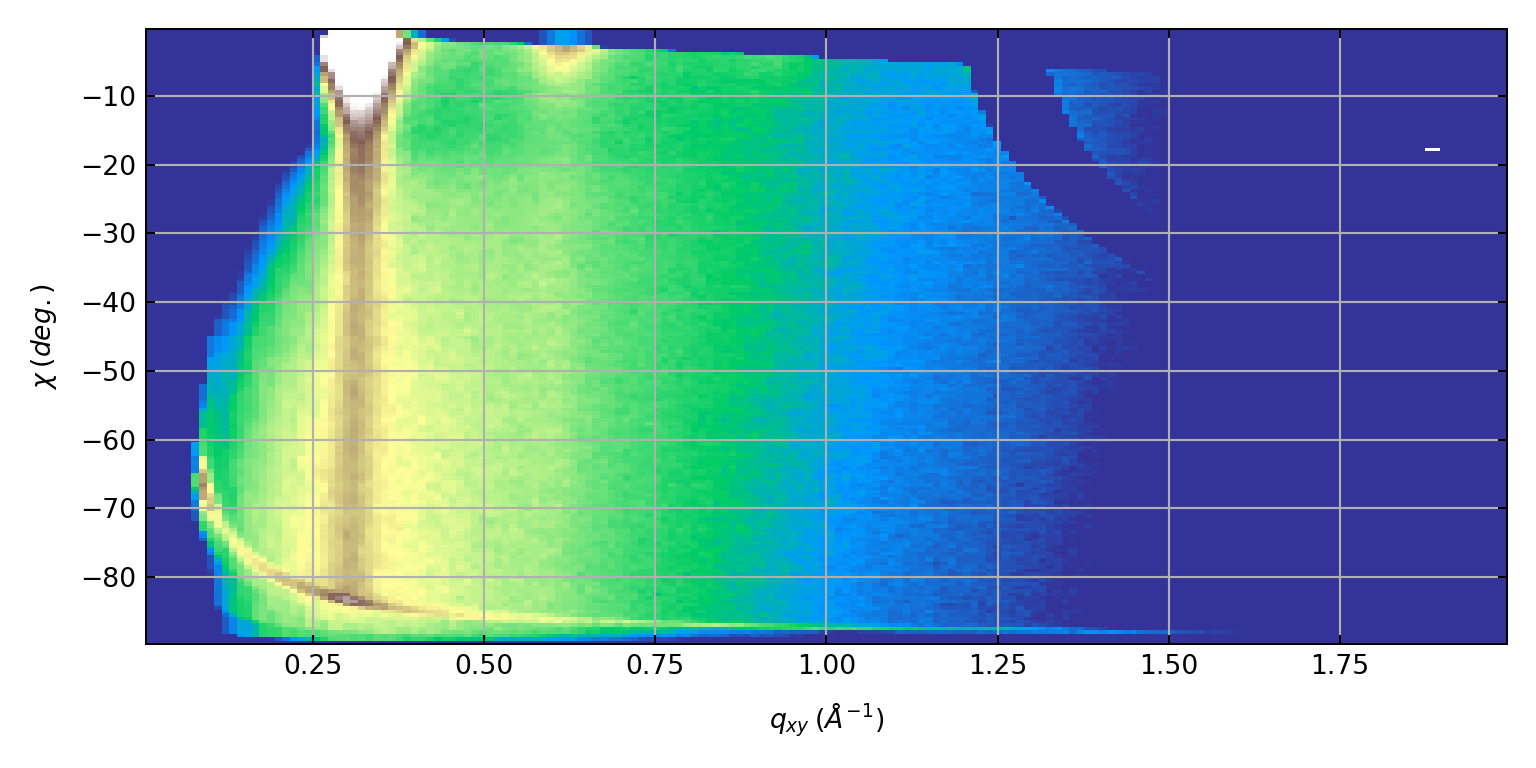

In [192]:
imgp, q_abs, chi = get_pole_figure(dfw, sample, os.path.join(nils_dir,'calib.csv'))
corrimg = imgp-np.min(imgp)+1
logimg = np.log(corrimg)

pcolor(logimg, figsize=(8,4),
       extent=[q_abs.min(), q_abs.max(), chi.min(), chi.max()],
       origin='lower', prcs=(40,99.5))
plt.xlabel(r'$q_{xy} \: (\AA^{-1})$')
plt.ylabel(r'$\chi \: (deg.)$')
plt.gca().grid(True)

## Let's add a blank

In [193]:
blank_files = glob.glob(os.path.join(nils_dir, 'blanks', '*.tiff'))
dfb = build_master_table(blank_files)
dfb

tiff        sample       t  \
0   /Users/nils/CC/CMS Data/Nils/insitu_air/blanks...   ahmad_blank  1010.9   
1   /Users/nils/CC/CMS Data/Nils/insitu_air/blanks...   ahmad_blank  1043.9   
2   /Users/nils/CC/CMS Data/Nils/insitu_air/blanks...   ahmad_blank  1077.0   
3   /Users/nils/CC/CMS Data/Nils/insitu_air/blanks...   ahmad_blank   171.8   
4   /Users/nils/CC/CMS Data/Nils/insitu_air/blanks...   ahmad_blank   175.9   
5   /Users/nils/CC/CMS Data/Nils/insitu_air/blanks...   ahmad_blank   179.9   
6   /Users/nils/CC/CMS Data/Nils/insitu_air/blanks...   ahmad_blank   183.9   
7   /Users/nils/CC/CMS Data/Nils/insitu_air/blanks...   ahmad_blank   187.9   
8   /Users/nils/CC/CMS Data/Nils/insitu_air/blanks...   ahmad_blank   637.0   
9   /Users/nils/CC/CMS Data/Nils/insitu_air/blanks...   ahmad_blank   670.1   
10  /Users/nils/CC/CMS Data/Nils/insitu_air/blanks...   ahmad_blank   703.0   
11  /Users/nils/CC/CMS Data/Nils/insitu_air/blanks...   ahmad_blank   736.9   
12  /Users/nils/CC/CMS Data/Nils/insitu_air/blanks...   ahmad_blank   771.0   
13  /Users/nils/CC/CMS Data/Nils/insitu_air/blanks...   ahmad_blank   805.0   
14  /Users/nils/CC/CMS Data/Nils/insitu_air/blanks...   ahmad_blank   912.1   
15  /Users/nils/CC/CMS Data/Nils/insitu_air/blanks...   ahmad_blank   945.0   
16  /Users/nils/CC/CMS Data/Nils/insitu_air/blanks...   ahmad_blank   978.0   
17  /Users/nils/CC/CMS Data/Nils/insitu_air/blanks...       si_pos1  5363.3   
18  /Users/nils/CC/CMS Data/Nils/insitu_air/blanks...       si_pos1  5383.3   
19  /Users/nils/CC/CMS Data/Nils/insitu_air/blanks...       si_pos1  5404.2   
20  /Users/nils/CC/CMS Data/Nils/insitu_air/blanks...       si_pos1  5425.2   
21  /Users/nils/CC/CMS Data/Nils/insitu_air/blanks...       si_pos1  5447.2   
22  /Users/nils/CC/CMS Data/Nils/insitu_air/blanks...       si_pos2  5373.2   
23  /Users/nils/CC/CMS Data/Nils/insitu_air/blanks...       si_pos2  5393.2   
24  /Users/nils/CC/CMS Data/Nils/insitu_air/blanks...       si_pos2  5414.2   
25  /Users/nils/CC/CMS Data/Nils/insitu_air/blanks...       si_pos2  5436.2   
26  /Users/nils/CC/CMS Data/Nils/insitu_air/blanks...       si_pos2  5458.2   
27  /Users/nils/CC/CMS Data/Nils/insitu_air/blanks...       test_si  1153.7   
28  /Users/nils/CC/CMS Data/Nils/insitu_air/blanks...       test_si   232.7   
29  /Users/nils/CC/CMS Data/Nils/insitu_air/blanks...       test_si   236.7   
30  /Users/nils/CC/CMS Data/Nils/insitu_air/blanks...       test_si   240.6   
31  /Users/nils/CC/CMS Data/Nils/insitu_air/blanks...       test_si   244.7   
32  /Users/nils/CC/CMS Data/Nils/insitu_air/blanks...       test_si   248.7   
33  /Users/nils/CC/CMS Data/Nils/insitu_air/blanks...       test_si   280.7   
34  /Users/nils/CC/CMS Data/Nils/insitu_air/blanks...       test_si   293.7   
35  /Users/nils/CC/CMS Data/Nils/insitu_air/blanks...       test_si   306.7   
36  /Users/nils/CC/CMS Data/Nils/insitu_air/blanks...       test_si   319.7   
37  /Users/nils/CC/CMS Data/Nils/insitu_air/blanks...       test_si   332.6   
38  /Users/nils/CC/CMS Data/Nils/insitu_air/blanks...       test_si   373.7   
39  /Users/nils/CC/CMS Data/Nils/insitu_air/blanks...       test_si   751.6   
40  /Users/nils/CC/CMS Data/Nils/insitu_air/blanks...       test_si   807.6   
41  /Users/nils/CC/CMS Data/Nils/insitu_air/blanks...       test_si   924.7   
42  /Users/nils/CC/CMS Data/Nils/insitu_air/blanks...       test_si   959.7   
43  /Users/nils/CC/CMS Data/Nils/insitu_air/blanks...  test_si_pos1  1006.7   
44  /Users/nils/CC/CMS Data/Nils/insitu_air/blanks...  test_si_pos1   104.6   
45  /Users/nils/CC/CMS Data/Nils/insitu_air/blanks...  test_si_pos1   217.6   
46  /Users/nils/CC/CMS Data/Nils/insitu_air/blanks...  test_si_pos1    27.6   
47  /Users/nils/CC/CMS Data/Nils/insitu_air/blanks...  test_si_pos1   854.7   
48  /Users/nils/CC/CMS Data/Nils/insitu_air/blanks...  test_si_pos1   974.7   
49  /Users/nils/CC/CMS Data/Nils/insitu_air/blanks...  test_si_pos2  1020.8   
50  /Users/nils/CC/C

## Define a function to make a transform with these parameters

In [194]:
sample=904
dfw.loc[sample]

tiff        /Users/nils/CC/CMS Data/Nils/insitu_air/ds30cn...
burst                                                     NaN
exp_time                                                   10
mode                                                     maxs
sample                                      ds30cn_30_w1_pos1
stamp                                                  994732
t                                                       272.8
theta                                                    0.15
Name: 904, dtype: object

In [195]:
def get_blank(dfb,dfw,sample,blank_set='si_pos1'):
    """ Given a sample row from a regular df, find blank with corresponding theta and
    scale for exposure time"""
    
    dfb_filter = dfb.loc[dfb['sample']==blank_set].loc[dfb['mode']==dfw['mode'].loc[sample]]
    dfb_sorted = dfb_filter.iloc[(dfb_filter['theta']-dfw['theta'].loc[sample]).abs().argsort()]
    blank_match = dfb_sorted.index.values[0]
    blank_raw = get_data(dfb_sorted, blank_match)
    blank_scaled = blank_raw * dfw['exp_time'].loc[sample] / dfb['exp_time'].loc[blank_match]

    return blank_scaled

2019-02-26 08:04:58,107 - fabio.TiffIO - WARNING - Data at tag id '65000' is smaller than expected


<IPython.core.display.Javascript object>


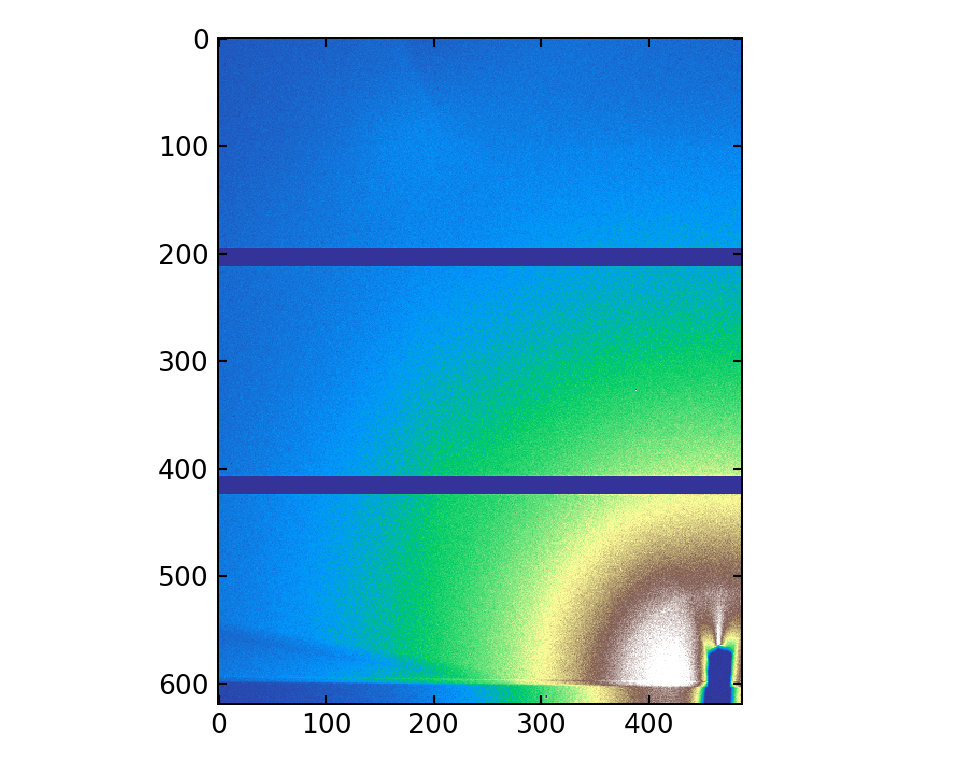

In [197]:
pcolor(get_blank(dfb,dfw,904, blank_set='si_pos1'), aspect='equal')

2019-02-26 08:05:11,655 - fabio.TiffIO - WARNING - Data at tag id '65000' is smaller than expected
2019-02-26 08:05:11,691 - fabio.TiffIO - WARNING - Data at tag id '65000' is smaller than expected
2019-02-26 08:05:11,717 - pygix.transform - INFO - pygix.Transform.transform_image: Resetting transformer because init


<IPython.core.display.Javascript object>


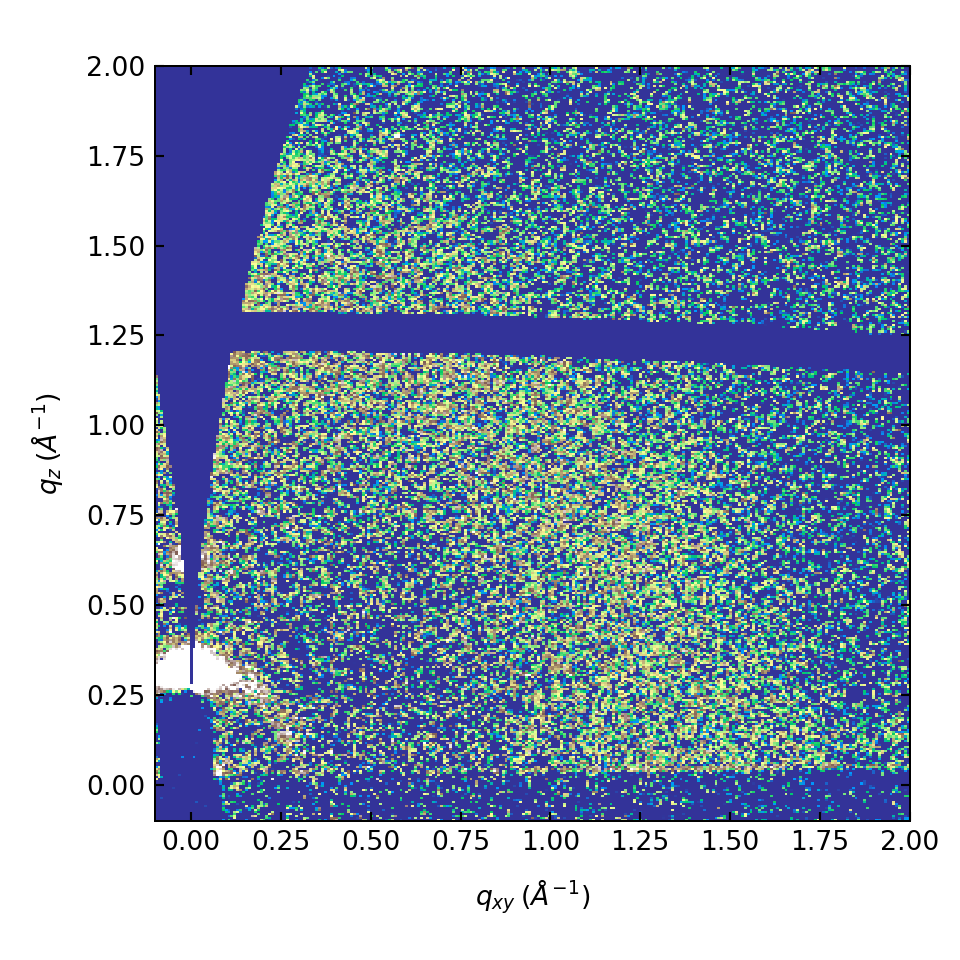

/anaconda/envs/pygix/lib/python3.6/site-packages/pygix-0.1.4a0-py3.6.egg/pygix/plotting.py:346: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif clim == 'auto':


In [199]:
samp = 800
show_sample(dfw, samp, dark=get_blank(dfb, dfw, samp, blank_set='si_pos1'))
# show_sample(dfw, samp)